In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

from time import time

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
import torch.optim as optim

In [3]:
torch.__version__

'0.4.0'

In [4]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [5]:
device = torch.device('cuda:7' if USE_CUDA else 'cpu')

In [6]:
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

In [7]:
batch_size = 100

In [8]:
kwargs = {'num_workers': 1, 'pin_memory': True} if USE_CUDA else {}

dataset = CIFAR10

train_loader = torch.utils.data.DataLoader(
    dataset(
        './data', train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

test_loader = torch.utils.data.DataLoader(
    dataset(
        './data', train=False, transform=transforms.ToTensor()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

Files already downloaded and verified


In [9]:
print(train_loader.dataset.train_data.shape)
print(test_loader.dataset.test_data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [10]:
from sklearn.model_selection import train_test_split

train_dataset_labelled, train_dataset_unlabelled, train_labels_labelled, train_labels_unlabelled = train_test_split(
    train_loader.dataset.train_data, np.array(train_loader.dataset.train_labels), train_size=4000
)
train_dataset_labelled.shape, train_dataset_unlabelled.shape, train_labels_labelled.shape, train_labels_unlabelled.shape

/home/golikov/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


((4000, 32, 32, 3), (46000, 32, 32, 3), (4000,), (46000,))

In [11]:
np.sum(np.array(train_loader.dataset.train_labels) == 0) / np.array(train_loader.dataset.train_labels).shape[0]

0.10000000000000001

In [12]:
np.max(train_dataset_labelled)

255

In [13]:
train_loader_labelled = DataLoader(
    TensorDataset(
        torch.from_numpy(np.transpose(train_dataset_labelled, (0,3,1,2))).float() / 255, 
        torch.Tensor(train_labels_labelled).long()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)
train_loader_unlabelled = DataLoader(
    TensorDataset(
        torch.from_numpy(np.transpose(train_dataset_unlabelled, (0,3,1,2))).float() / 255, 
        torch.Tensor(train_labels_unlabelled).long()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

In [14]:
input_shape = train_loader.dataset.train_data.shape[1:]
input_shape = input_shape[-1:] + input_shape[:-1]
output_size = 10

**WAE-WGAN**

In [15]:
def binary_crossentropy_loss(x_true, x_distr):
    """
    Вычисляет бинарную кроссэнтропию между эмприческим распределением на данные
    и индуцированным моделью распределением, т. е. правдоподобие объектов x_true.
    Каждому объекту из x_true соответствуют K сэмплированных распределений
    на x из x_distr.
    i-му объекту соответствуют распределения с номерами i * K, ..., (i + 1) * K - 1.
    Требуется вычислить оценку логарифма правдоподобия для каждого объекта.
    Подсказка: не забывайте про вычислительную стабильность!

    Вход: x_true, Variable - матрица объектов размера n x D.
    Вход: x_distr, Variable - матрица параметров распределений Бернулли
    размера (n * K) x D.
    Выход: Variable, матрица размера n x K - оценки логарифма правдоподобия
    каждого сэмпла.
    """
    K = x_distr.shape[0] // x_true.shape[0]
    #print(x_true.shape, x_distr.shape)
    n, D = x_true.shape
    eps = 1e-5
    x_distr = torch.clamp(x_distr.view(n, K, D), eps, 1-eps)
    x_true = x_true.view(n, 1, D)
    return -torch.sum(torch.log(x_distr) * x_true + torch.log(1 - x_distr) * (1 - x_true), dim=2)

In [16]:
class ReshapeLayer(nn.Module):
    def __init__(self, *args):
        super(ReshapeLayer, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)

In [17]:
class GeneratorConditioned(nn.Module):
    def __init__(self, input_shape, output_dim=512, noise_magnitude=0.0):
        super(type(self), self).__init__()
        assert input_shape[1] == input_shape[2] # [3 x 32 x 32]
        self.noise_magnitude = noise_magnitude

        self.image_processor = nn.Sequential(
            nn.Conv2d(input_shape[0], 128, 4, padding=2, stride=2), # [128 x 17 x 17]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 5, padding=2, stride=2), # [256 x 9 x 9]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, 5, padding=2, stride=2), # [512 x 5 x 5]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, 5, padding=2, stride=2), # [1024 x 3 x 3]
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            ReshapeLayer(1024 * 3 * 3),
            nn.Linear(1024 * 3 * 3, output_dim) # [output_dim]
        )

    def forward(self, X, Z=None):
        if Z is None:
            Z = torch.normal(mean=torch.zeros_like(X)) * self.noise_magnitude
        return self.image_processor(X + Z)

In [18]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, hidden_count=4):
        super(type(self), self).__init__()

        self.layers = nn.ModuleList([
            ReshapeLayer(-1),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        ])
        for _ in range(hidden_count-1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(hidden_dim, 1))

    def forward(self, X):
        Z = X
        for layer in self.layers:
            Z = layer(Z)
        return Z

In [19]:
class WAE_WGAN(nn.Module):
    def __init__(self, input_shape, latent_dim):

        super(type(self), self).__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        
        self.proposal_generator = GeneratorConditioned(input_shape, output_dim=latent_dim)
        self.proposal_discriminator = Discriminator(latent_dim)
        
        self.generative_network = nn.Sequential(
            nn.Linear(latent_dim, 1024 * 4 * 4),
            ReshapeLayer(1024, 4, 4), # [1024 x 4 x 4]
            nn.ConvTranspose2d(1024, 512, 5, padding=1, stride=2), # [512 x 9 x 9]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 5, padding=2, stride=2), # [256 x 17 x 17]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, padding=2, stride=2), # [128 x 32 x 32]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 3, 1), # [3 x 32 x 32]
            #nn.Sigmoid()
        )

    def prior_distr(self, n):
        mu = torch.zeros(n, self.latent_dim, device=device)
        sigma = torch.ones(n, self.latent_dim, device=device)
        return mu, sigma

    def sample_latent(self, X):
        return self.proposal_generator(X)

    def sample_prior(self, num_samples):
        return torch.normal(*self.prior_distr(num_samples))

    def generative_distr(self, z):
        return self.generative_network(z)

    def batch_loss(self, X, 
                   return_reconstruction_loss=True, return_discriminator_loss=True, return_lipschitz_loss=True):
        n = X.shape[0]
        Z = self.sample_latent(X)
        Z_prior = self.sample_prior(n)
        if return_reconstruction_loss:
            X_rec = self.generative_distr(Z)
            reconstruction_loss = torch.sum((X_rec - X) ** 2) / n
            #reconstruction_loss = torch.sum(torch.abs(X_rec - X)) / n
            #reconstruction_loss = torch.sum(binary_crossentropy_loss(X.view(n, -1), X_rec.view(n, -1))) / n
        else:
            reconstruction_loss = None
        if return_discriminator_loss:
            discriminator_loss = torch.mean(self.proposal_discriminator(Z_prior) - self.proposal_discriminator(Z))
        else:
            discriminator_loss = None
        if return_lipschitz_loss:
            eps = torch.rand(n, 1, device=device)
            Z_hat = (Z_prior.detach() * eps + Z.detach() * (1 - eps)).requires_grad_()
            value_hat = self.proposal_discriminator(Z_hat)
            value_hat_grad_sqr_norm = torch.sum(
                autograd.grad([torch.sum(value_hat)], [Z_hat], create_graph=True)[0].view(n, -1) ** 2, dim=-1
            )
            lipschitz_loss = torch.mean((torch.sqrt(value_hat_grad_sqr_norm) - 1) ** 2)
        else:
            lipschitz_loss = None
        return reconstruction_loss, discriminator_loss, lipschitz_loss

    def generate_samples(self, num_samples):
        return self.generative_distr(self.sample_prior(num_samples))

In [20]:
def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(np.transpose(x.data[i].to(torch.device('cpu')).numpy(), axes=(1,2,0)), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
        plt.axis('off')

In [21]:
latent_dim = 64

num_epochs = 100
save_every = 10

name_prefix = 'wae_gan_results/'

try:
#if True:
    wae = WAE_WGAN(input_shape, latent_dim).to(device)
    wae.load_state_dict(torch.load(name_prefix + 'wae_gan.pt'))
    print("Found pretrained WAE-GAN")
except:
    print("Didn't found pretrained WAE-GAN; training...")
    
    wae = WAE_WGAN(input_shape, latent_dim).to(device)
    optimizer = optim.Adam(
        list(wae.proposal_generator.parameters()) + list(wae.generative_network.parameters()), 
        lr=3e-4, betas=(0.5, 0.999)
    )
    optimizer_discriminator = optim.Adam(wae.proposal_discriminator.parameters(), lr=1e-3, betas=(0.5, 0.999))

    scheduler = optim.lr_scheduler.LambdaLR(
        optimizer, lambda n: 1 if n < 30 else 0.5 if n < 50 else 0.1 if n < 100 else 0.01
    )
    scheduler_discriminator = optim.lr_scheduler.LambdaLR(
        optimizer_discriminator, lambda n: 1 if n < 30 else 0.5 if n < 50 else 0.1 if n < 100 else 0.01
    )

    for epoch in range(num_epochs):
        start_time = time()
        
        scheduler.step()
        scheduler_discriminator.step()
        
        regularization_factor = 10
        lipschitz_contraint_factor = 2
        update_generator_every = 2
        
        cum_loss_reconstruction = 0
        cum_loss_discriminator = 0
        cum_loss_lipschitz = 0
        batch_count = 0
        
        for X_batch, _ in train_loader:
            X_batch = X_batch.to(device)

            do_discriminator_update = (
                epoch * len(train_loader.dataset.train_labels) // X_batch.shape[0] + batch_count
            ) % update_generator_every > 0
        
            if do_discriminator_update:
                _, loss_discriminator, loss_lipschitz = wae.batch_loss(X_batch, return_reconstruction_loss=False)
                cum_loss_discriminator += loss_discriminator.item()
                cum_loss_lipschitz += loss_lipschitz.item()
                
                optimizer_discriminator.zero_grad()
                (loss_discriminator + loss_lipschitz * lipschitz_contraint_factor).backward()
                optimizer_discriminator.step()
            else:
                loss_reconstruction, loss_discriminator, _ = wae.batch_loss(X_batch, return_lipschitz_loss=False)
                cum_loss_reconstruction += loss_reconstruction.item()
                cum_loss_discriminator += loss_discriminator.item()
                
                optimizer.zero_grad()
                (loss_reconstruction - loss_discriminator * regularization_factor).backward()
                optimizer.step()
            batch_count += 1
    
        mean_train_loss_reconstruction = cum_loss_reconstruction / (batch_count / update_generator_every)
        mean_train_loss_discriminator = cum_loss_discriminator / batch_count
        mean_train_loss_lipschitz = cum_loss_lipschitz / \
                                    ((update_generator_every - 1) * batch_count / update_generator_every)

        cum_loss_reconstruction = 0
        cum_loss_discriminator = 0
        cum_loss_lipschitz = 0
        batch_count = 0
        
        with torch.no_grad():
            for X_batch, _ in test_loader:
                X_batch = X_batch.to(device)

                loss_reconstruction, loss_discriminator, _ = wae.batch_loss(X_batch, return_lipschitz_loss=False)
                cum_loss_reconstruction += loss_reconstruction.item()
                cum_loss_discriminator += loss_discriminator.item()
                #cum_loss_lipschitz += loss_lipschitz.item()
        
                batch_count += 1
            
        mean_test_loss_reconstruction = cum_loss_reconstruction / batch_count
        mean_test_loss_discriminator = cum_loss_discriminator / batch_count
        mean_test_loss_lipschitz = cum_loss_lipschitz / batch_count

        print('Epoch {} of {} took {:.2f}s;'.format(epoch+1, num_epochs, time() - start_time))
        print('train reconstruction loss: {:.2f}; test reconstruction loss: {:.2f}'.format(
            mean_train_loss_reconstruction, mean_test_loss_reconstruction
        ))
        print('train discriminator loss: {:.2f}; test discriminator loss: {:.2f}'.format(
            mean_train_loss_discriminator, mean_test_loss_discriminator
        ))
        print('train lipschitz loss: {:.2f}; test lipschitz loss: {:.2f}'.format(
            mean_train_loss_lipschitz, mean_test_loss_lipschitz
        ))
        
        if (epoch+1) % 5 == 0:
            X_batch = next(iter(train_loader))[0][:10].to(device)
            show_images(X_batch)
            plt.show()
            show_images(
                wae.generative_network(
                    wae.proposal_generator(X_batch)
                )
            )
            plt.show()
            show_images(wae.generate_samples(10))
            plt.show()
    
        if (epoch+1) % save_every == 0:
            torch.save(wae.state_dict(), name_prefix + 'wae_gan.pt')
        
    print()


Found pretrained WAE-GAN


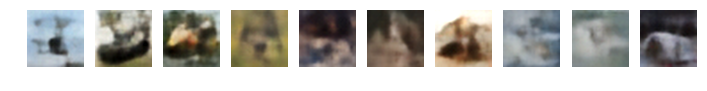

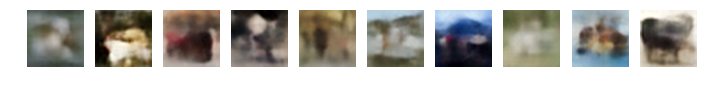

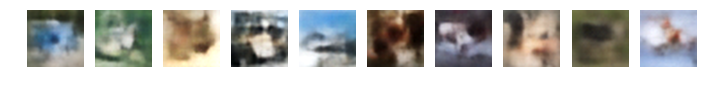

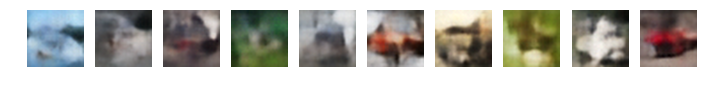

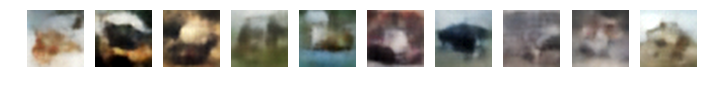

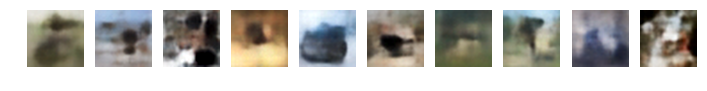

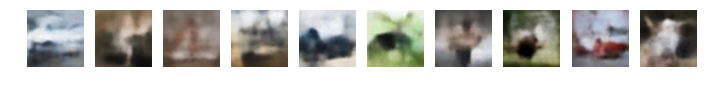

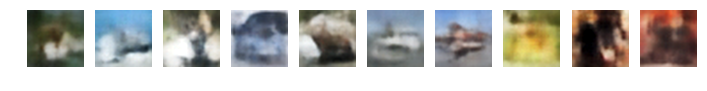

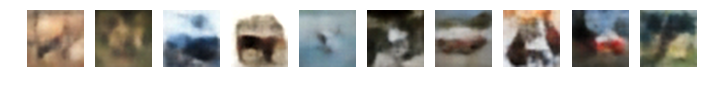

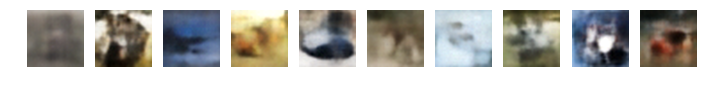

In [22]:
for label in range(10):
    show_images(wae.generate_samples(10))
    plt.show()

**Tangent prop**

In [23]:
def constrain_loss_function(model, generative_model, batch_gen=None, reparam_invariant=True, use_all_classes=False):
    latent_dim = generative_model.latent_dim
    
    if reparam_invariant:
        if batch_gen is None:
            z_gen = torch.normal(std=torch.ones(batch_size, latent_dim, device=device)) # [batch_size x latent_dim]
            X_gen = generative_model.generative_distr(z_gen).detach().requires_grad_() # [batch_size x C x H x W]
        else:
            X_gen, _ = next(batch_gen)
            X_gen = X_gen.to(device).requires_grad_()
        z_inferred = generative_model.sample_latent(X_gen) # [batch_size x latent_dim]
    else:
        if batch_gen is None:
            z_inferred = torch.normal(
                std=torch.ones(batch_size, latent_dim, device=device)
            ).requires_grad_() # [batch_size x latent_dim]
        else:
            X, _ = next(batch_gen)
            X = X.to(device)
            z_inferred = generative_model.sample_latent(X).detach().requires_grad_() # [batch_size x latent_dim]
    X_inferred = generative_model.generative_distr(z_inferred) # [batch_size x C x H x W]
    model_output = model(X_inferred) # [batch_size x num_classes]
    
    if use_all_classes:
        grad_output_wrt_input_for_each_class = []
        for output in torch.unbind(torch.sum(model_output, dim=0)):
            grad_output_wrt_input_for_each_class.append(
                autograd.grad([output], [X_gen if reparam_invariant else z_inferred], create_graph=True)[0]
            ) # [batch_size x latent_dim]
        grad_output_wrt_input = torch.stack(
            grad_output_wrt_input_for_each_class
        ) # [num_classes x batch_size x latent_dim]
        return torch.sum(grad_output_wrt_input ** 2) / batch_size
    else:
        y = np.random.choice(output_size)
        output = torch.sum(model_output, dim=0)[y]
        grad_output_wrt_input = autograd.grad(
            [output], [X_gen if reparam_invariant else z_inferred], create_graph=True
        )[0]
        return output_size * torch.sum(grad_output_wrt_input ** 2) / batch_size

**Training**

In [24]:
class ModelConvolutional(nn.Module):
    def __init__(
        self, input_shape, output_size 
    ):
        super(type(self), self).__init__()
        assert input_shape[1] == input_shape[2]
        self.layers = nn.ModuleList([
            nn.Dropout(p=0.2),
            nn.Conv2d(input_shape[0], 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(96),
            
            nn.Dropout(p=0.5),
            nn.Conv2d(96, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(192),
            
            nn.Dropout(p=0.5),
            nn.Conv2d(192, 192, 3),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.AvgPool2d(6)
        ])
        self.output_layer = nn.utils.weight_norm(nn.Linear(192, 10))
        
    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        X = X.view(X.shape[0], -1)
        return F.log_softmax(self.output_layer(X), dim=1)

In [25]:
train_losses = {}
train_accs = {}

test_losses = {}
test_accs = {}

In [26]:
num_epochs = 200
num_runs = 5
save_every = 10

modes = ['stochastic_manifold_reg_on_train_data__eta=' + str(eta) for eta in [0, 1e-5, 1e-4, 1e-3, 1e-2]]

loss_function = nn.NLLLoss()

for mode in modes:
    mode_name = mode + '__labelled=4000__epochs=' + str(num_epochs)
    eta = float(mode.split('=')[1])

    print('Mode:', mode)
    print(mode_name)
    print('eta =', eta)
    print()
    
    train_losses[mode] = []
    train_accs[mode] = []
    
    test_losses[mode] = []
    test_accs[mode] = []

    torch.manual_seed(123)
    np.random.seed(123)
    for run in range(num_runs):
        print('run', run+1)
        
        train_losses[mode].append([])
        train_accs[mode].append([])
    
        test_losses[mode].append([])
        test_accs[mode].append([])

        model = ModelConvolutional(input_shape, output_size).to(device)
        optimizer = optim.Adam(model.parameters(), lr=3e-4, betas=(0.5, 0.999))
        #scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda k: ((num_epochs-k)/200 if k >= num_epochs-200 else 1))
    
        for epoch in range(num_epochs):
            start_time = time()
    
            #scheduler.step()
    
            cum_loss_data = 0
            cum_loss_constrain = 0
            cum_loss_full = 0
            cum_acc = 0
            batch_count = 0

            model.train()
            train_iter_unlabelled = iter(train_loader_unlabelled)
            for X, y in train_loader_labelled:
                X, y = X.to(device), y.to(device)
                prediction = model(X)
                loss_data = loss_function(prediction, y)
                cum_loss_data += loss_data.item()
        
                loss_constrain = constrain_loss_function(
                    model, wae, reparam_invariant=True, use_all_classes=False, batch_gen=train_iter_unlabelled
                )
                cum_loss_constrain += loss_constrain.item()
        
                loss_full = loss_data + eta * loss_constrain
                cum_loss_full += loss_full.item()
            
                acc = torch.mean((torch.max(prediction, dim=-1)[1] == y).float())
                cum_acc += acc.item()
        
                optimizer.zero_grad()
                loss_full.backward()
                optimizer.step()
                batch_count += 1
            
            mean_train_loss_data = cum_loss_data / batch_count
            mean_train_loss_constrain = cum_loss_constrain / batch_count
            mean_train_loss_full = cum_loss_full / batch_count
            mean_train_acc = cum_acc / batch_count

            train_losses[mode][-1].append(mean_train_loss_data)
            train_accs[mode][-1].append(mean_train_acc)
        
            cum_loss_data = 0
            cum_loss_constrain = 0
            cum_acc = 0
            batch_count = 0

            model.eval()
            with torch.no_grad():
                for X, y in test_loader:
                    X, y = X.to(device), y.to(device)
                    prediction = model(X)
                    loss_data = loss_function(prediction, y)
                    cum_loss_data += loss_data.item()
        
                    acc = torch.mean((torch.max(prediction, dim=-1)[1] == y).float())
                    cum_acc += acc.item()
        
                    batch_count += 1
            
            mean_test_loss_data = cum_loss_data / batch_count
            mean_test_loss_constrain = cum_loss_constrain / batch_count
            mean_test_acc = cum_acc / batch_count

            test_losses[mode][-1].append(mean_test_loss_data)
            test_accs[mode][-1].append(mean_test_acc)
        
            print('Epoch {} of {} took {:.2f}s;'.format(epoch+1, num_epochs, time() - start_time))
            print('train loss:')
            print(
                'data term: {:.2f}, constrain term: {:.2f}, full: {:.2f}'.format(
                    mean_train_loss_data, mean_train_loss_constrain, mean_train_loss_full
                )
            )
            print('train acc: {:.2f}'.format(mean_train_acc*100))
            print('test loss:')
            print(
                'data term: {:.2f}, constrain term: {:.2f}'.format(
                    mean_test_loss_data, mean_test_loss_constrain
                )
            )
            print('test acc: {:.2f}'.format(mean_test_acc*100))
            print()
        
            if (epoch+1) % save_every == 0:
                with open(name_prefix + mode_name + '/train_losses.pkl', 'wb') as f:
                    pickle.dump(np.array(train_losses[mode]), f)
                with open(name_prefix + mode_name + '/test_losses.pkl', 'wb') as f:
                    pickle.dump(np.array(test_losses[mode]), f)
                with open(name_prefix + mode_name + '/train_accs.pkl', 'wb') as f:
                    pickle.dump(np.array(train_accs[mode]), f)
                with open(name_prefix + mode_name + '/test_accs.pkl', 'wb') as f:
                    pickle.dump(np.array(test_accs[mode]), f)

                torch.save(model.state_dict(), name_prefix + mode_name + '/model.pt')

    train_losses[mode] = np.array(train_losses[mode])
    test_losses[mode] = np.array(test_losses[mode])
    train_accs[mode] = np.array(train_accs[mode])
    test_accs[mode] = np.array(test_accs[mode])
    

Mode: stochastic_manifold_reg_on_train_data__eta=0
stochastic_manifold_reg_on_train_data__eta=0__labelled=4000__epochs=200
eta = 0.0

run 1
Epoch 1 of 200 took 24.96s;
train loss:
data term: 2.01, constrain term: 0.04, full: 2.01
train acc: 26.45
test loss:
data term: 2.13, constrain term: 0.00
test acc: 23.05

Epoch 2 of 200 took 24.68s;
train loss:
data term: 1.80, constrain term: 0.21, full: 1.80
train acc: 34.58
test loss:
data term: 2.12, constrain term: 0.00
test acc: 23.85

Epoch 3 of 200 took 25.08s;
train loss:
data term: 1.71, constrain term: 0.43, full: 1.71
train acc: 38.17
test loss:
data term: 2.00, constrain term: 0.00
test acc: 26.61

Epoch 4 of 200 took 24.62s;
train loss:
data term: 1.64, constrain term: 0.70, full: 1.64
train acc: 40.20
test loss:
data term: 1.94, constrain term: 0.00
test acc: 29.53

Epoch 5 of 200 took 24.90s;
train loss:
data term: 1.59, constrain term: 0.95, full: 1.59
train acc: 43.17
test loss:
data term: 1.90, constrain term: 0.00
test acc: 28

Epoch 48 of 200 took 24.68s;
train loss:
data term: 0.56, constrain term: 49.91, full: 0.56
train acc: 81.32
test loss:
data term: 1.23, constrain term: 0.00
test acc: 60.77

Epoch 49 of 200 took 24.64s;
train loss:
data term: 0.53, constrain term: 53.75, full: 0.53
train acc: 83.02
test loss:
data term: 1.13, constrain term: 0.00
test acc: 62.65

Epoch 50 of 200 took 24.64s;
train loss:
data term: 0.52, constrain term: 57.54, full: 0.52
train acc: 83.00
test loss:
data term: 1.22, constrain term: 0.00
test acc: 60.18

Epoch 51 of 200 took 24.94s;
train loss:
data term: 0.49, constrain term: 60.32, full: 0.49
train acc: 85.17
test loss:
data term: 1.13, constrain term: 0.00
test acc: 62.71

Epoch 52 of 200 took 24.93s;
train loss:
data term: 0.48, constrain term: 60.02, full: 0.48
train acc: 85.55
test loss:
data term: 1.26, constrain term: 0.00
test acc: 58.79

Epoch 53 of 200 took 24.64s;
train loss:
data term: 0.46, constrain term: 60.12, full: 0.46
train acc: 85.27
test loss:
data 

Epoch 95 of 200 took 24.66s;
train loss:
data term: 0.12, constrain term: 203.26, full: 0.12
train acc: 97.45
test loss:
data term: 1.27, constrain term: 0.00
test acc: 65.49

Epoch 96 of 200 took 24.65s;
train loss:
data term: 0.13, constrain term: 203.79, full: 0.13
train acc: 96.65
test loss:
data term: 1.30, constrain term: 0.00
test acc: 64.81

Epoch 97 of 200 took 24.67s;
train loss:
data term: 0.12, constrain term: 211.47, full: 0.12
train acc: 97.20
test loss:
data term: 1.34, constrain term: 0.00
test acc: 64.29

Epoch 98 of 200 took 24.66s;
train loss:
data term: 0.12, constrain term: 218.47, full: 0.12
train acc: 96.78
test loss:
data term: 1.47, constrain term: 0.00
test acc: 62.59

Epoch 99 of 200 took 24.69s;
train loss:
data term: 0.12, constrain term: 213.52, full: 0.12
train acc: 96.75
test loss:
data term: 1.39, constrain term: 0.00
test acc: 63.43

Epoch 100 of 200 took 24.73s;
train loss:
data term: 0.10, constrain term: 226.83, full: 0.10
train acc: 97.75
test loss

Epoch 142 of 200 took 24.67s;
train loss:
data term: 0.06, constrain term: 376.08, full: 0.06
train acc: 98.53
test loss:
data term: 1.68, constrain term: 0.00
test acc: 63.77

Epoch 143 of 200 took 24.66s;
train loss:
data term: 0.07, constrain term: 362.79, full: 0.07
train acc: 98.35
test loss:
data term: 1.63, constrain term: 0.00
test acc: 62.95

Epoch 144 of 200 took 24.74s;
train loss:
data term: 0.06, constrain term: 357.34, full: 0.06
train acc: 98.38
test loss:
data term: 1.58, constrain term: 0.00
test acc: 63.73

Epoch 145 of 200 took 24.66s;
train loss:
data term: 0.06, constrain term: 376.89, full: 0.06
train acc: 98.35
test loss:
data term: 1.46, constrain term: 0.00
test acc: 64.66

Epoch 146 of 200 took 24.66s;
train loss:
data term: 0.06, constrain term: 374.38, full: 0.06
train acc: 98.78
test loss:
data term: 1.55, constrain term: 0.00
test acc: 65.22

Epoch 147 of 200 took 24.68s;
train loss:
data term: 0.06, constrain term: 382.41, full: 0.06
train acc: 98.13
test

Epoch 189 of 200 took 24.67s;
train loss:
data term: 0.03, constrain term: 482.72, full: 0.03
train acc: 99.30
test loss:
data term: 1.66, constrain term: 0.00
test acc: 64.88

Epoch 190 of 200 took 24.63s;
train loss:
data term: 0.06, constrain term: 476.68, full: 0.06
train acc: 98.10
test loss:
data term: 1.54, constrain term: 0.00
test acc: 66.30

Epoch 191 of 200 took 24.65s;
train loss:
data term: 0.03, constrain term: 504.88, full: 0.03
train acc: 99.08
test loss:
data term: 1.47, constrain term: 0.00
test acc: 67.29

Epoch 192 of 200 took 24.63s;
train loss:
data term: 0.04, constrain term: 494.07, full: 0.04
train acc: 98.93
test loss:
data term: 1.49, constrain term: 0.00
test acc: 66.97

Epoch 193 of 200 took 24.65s;
train loss:
data term: 0.04, constrain term: 496.17, full: 0.04
train acc: 98.83
test loss:
data term: 1.65, constrain term: 0.00
test acc: 65.57

Epoch 194 of 200 took 24.63s;
train loss:
data term: 0.04, constrain term: 479.71, full: 0.04
train acc: 98.80
test

Epoch 36 of 200 took 24.65s;
train loss:
data term: 0.75, constrain term: 26.55, full: 0.75
train acc: 74.73
test loss:
data term: 1.20, constrain term: 0.00
test acc: 57.73

Epoch 37 of 200 took 24.67s;
train loss:
data term: 0.72, constrain term: 28.19, full: 0.72
train acc: 76.22
test loss:
data term: 1.16, constrain term: 0.00
test acc: 60.12

Epoch 38 of 200 took 24.65s;
train loss:
data term: 0.70, constrain term: 30.72, full: 0.70
train acc: 76.70
test loss:
data term: 1.22, constrain term: 0.00
test acc: 57.95

Epoch 39 of 200 took 24.69s;
train loss:
data term: 0.68, constrain term: 30.70, full: 0.68
train acc: 77.80
test loss:
data term: 1.27, constrain term: 0.00
test acc: 56.74

Epoch 40 of 200 took 24.75s;
train loss:
data term: 0.67, constrain term: 34.14, full: 0.67
train acc: 78.20
test loss:
data term: 1.13, constrain term: 0.00
test acc: 61.46

Epoch 41 of 200 took 24.85s;
train loss:
data term: 0.66, constrain term: 36.17, full: 0.66
train acc: 78.70
test loss:
data 

Epoch 83 of 200 took 24.65s;
train loss:
data term: 0.17, constrain term: 159.73, full: 0.17
train acc: 95.88
test loss:
data term: 1.31, constrain term: 0.00
test acc: 62.86

Epoch 84 of 200 took 24.68s;
train loss:
data term: 0.16, constrain term: 170.87, full: 0.16
train acc: 95.65
test loss:
data term: 1.38, constrain term: 0.00
test acc: 62.59

Epoch 85 of 200 took 24.74s;
train loss:
data term: 0.15, constrain term: 166.66, full: 0.15
train acc: 96.48
test loss:
data term: 1.25, constrain term: 0.00
test acc: 64.42

Epoch 86 of 200 took 24.67s;
train loss:
data term: 0.15, constrain term: 169.71, full: 0.15
train acc: 95.98
test loss:
data term: 1.28, constrain term: 0.00
test acc: 65.23

Epoch 87 of 200 took 24.71s;
train loss:
data term: 0.15, constrain term: 176.72, full: 0.15
train acc: 96.08
test loss:
data term: 1.51, constrain term: 0.00
test acc: 61.10

Epoch 88 of 200 took 24.67s;
train loss:
data term: 0.14, constrain term: 179.15, full: 0.14
train acc: 96.63
test loss:

Epoch 130 of 200 took 24.67s;
train loss:
data term: 0.05, constrain term: 325.12, full: 0.05
train acc: 99.25
test loss:
data term: 1.29, constrain term: 0.00
test acc: 68.07

Epoch 131 of 200 took 24.88s;
train loss:
data term: 0.06, constrain term: 321.19, full: 0.06
train acc: 98.33
test loss:
data term: 1.43, constrain term: 0.00
test acc: 65.09

Epoch 132 of 200 took 24.67s;
train loss:
data term: 0.06, constrain term: 332.59, full: 0.06
train acc: 98.65
test loss:
data term: 1.31, constrain term: 0.00
test acc: 66.19

Epoch 133 of 200 took 24.63s;
train loss:
data term: 0.06, constrain term: 338.51, full: 0.06
train acc: 98.68
test loss:
data term: 1.42, constrain term: 0.00
test acc: 64.65

Epoch 134 of 200 took 24.66s;
train loss:
data term: 0.07, constrain term: 332.63, full: 0.07
train acc: 97.98
test loss:
data term: 1.37, constrain term: 0.00
test acc: 65.85

Epoch 135 of 200 took 24.65s;
train loss:
data term: 0.05, constrain term: 335.21, full: 0.05
train acc: 98.63
test

Epoch 177 of 200 took 24.68s;
train loss:
data term: 0.04, constrain term: 458.06, full: 0.04
train acc: 99.18
test loss:
data term: 1.57, constrain term: 0.00
test acc: 66.73

Epoch 178 of 200 took 24.67s;
train loss:
data term: 0.04, constrain term: 456.50, full: 0.04
train acc: 99.10
test loss:
data term: 1.65, constrain term: 0.00
test acc: 64.69

Epoch 179 of 200 took 24.61s;
train loss:
data term: 0.06, constrain term: 448.74, full: 0.06
train acc: 98.25
test loss:
data term: 1.62, constrain term: 0.00
test acc: 64.55

Epoch 180 of 200 took 24.62s;
train loss:
data term: 0.04, constrain term: 451.75, full: 0.04
train acc: 98.88
test loss:
data term: 1.67, constrain term: 0.00
test acc: 65.28

Epoch 181 of 200 took 24.86s;
train loss:
data term: 0.04, constrain term: 466.87, full: 0.04
train acc: 99.03
test loss:
data term: 1.76, constrain term: 0.00
test acc: 62.57

Epoch 182 of 200 took 24.65s;
train loss:
data term: 0.04, constrain term: 465.04, full: 0.04
train acc: 98.85
test

Epoch 24 of 200 took 24.73s;
train loss:
data term: 1.02, constrain term: 12.09, full: 1.02
train acc: 64.80
test loss:
data term: 1.45, constrain term: 0.00
test acc: 48.46

Epoch 25 of 200 took 25.05s;
train loss:
data term: 1.01, constrain term: 13.11, full: 1.01
train acc: 65.10
test loss:
data term: 1.32, constrain term: 0.00
test acc: 52.72

Epoch 26 of 200 took 24.73s;
train loss:
data term: 0.98, constrain term: 13.40, full: 0.98
train acc: 65.90
test loss:
data term: 1.32, constrain term: 0.00
test acc: 51.62

Epoch 27 of 200 took 24.72s;
train loss:
data term: 0.96, constrain term: 14.35, full: 0.96
train acc: 66.90
test loss:
data term: 1.30, constrain term: 0.00
test acc: 54.30

Epoch 28 of 200 took 24.69s;
train loss:
data term: 0.94, constrain term: 15.44, full: 0.94
train acc: 68.05
test loss:
data term: 1.39, constrain term: 0.00
test acc: 51.68

Epoch 29 of 200 took 24.97s;
train loss:
data term: 0.92, constrain term: 16.76, full: 0.92
train acc: 68.25
test loss:
data 

Epoch 71 of 200 took 24.84s;
train loss:
data term: 0.25, constrain term: 109.98, full: 0.25
train acc: 93.25
test loss:
data term: 1.40, constrain term: 0.00
test acc: 60.63

Epoch 72 of 200 took 24.65s;
train loss:
data term: 0.25, constrain term: 113.21, full: 0.25
train acc: 93.10
test loss:
data term: 1.34, constrain term: 0.00
test acc: 60.76

Epoch 73 of 200 took 24.63s;
train loss:
data term: 0.24, constrain term: 115.33, full: 0.24
train acc: 92.73
test loss:
data term: 1.44, constrain term: 0.00
test acc: 57.95

Epoch 74 of 200 took 24.67s;
train loss:
data term: 0.25, constrain term: 113.45, full: 0.25
train acc: 93.00
test loss:
data term: 1.30, constrain term: 0.00
test acc: 61.85

Epoch 75 of 200 took 24.67s;
train loss:
data term: 0.21, constrain term: 122.43, full: 0.21
train acc: 94.63
test loss:
data term: 1.48, constrain term: 0.00
test acc: 60.41

Epoch 76 of 200 took 24.66s;
train loss:
data term: 0.21, constrain term: 130.36, full: 0.21
train acc: 94.35
test loss:

Epoch 118 of 200 took 24.65s;
train loss:
data term: 0.07, constrain term: 265.45, full: 0.07
train acc: 98.33
test loss:
data term: 1.41, constrain term: 0.00
test acc: 64.55

Epoch 119 of 200 took 24.65s;
train loss:
data term: 0.08, constrain term: 269.26, full: 0.08
train acc: 97.95
test loss:
data term: 1.35, constrain term: 0.00
test acc: 66.42

Epoch 120 of 200 took 24.66s;
train loss:
data term: 0.07, constrain term: 279.85, full: 0.07
train acc: 98.23
test loss:
data term: 1.43, constrain term: 0.00
test acc: 64.91

Epoch 121 of 200 took 24.94s;
train loss:
data term: 0.09, constrain term: 289.56, full: 0.09
train acc: 97.58
test loss:
data term: 1.88, constrain term: 0.00
test acc: 59.16

Epoch 122 of 200 took 24.62s;
train loss:
data term: 0.10, constrain term: 282.69, full: 0.10
train acc: 97.25
test loss:
data term: 1.45, constrain term: 0.00
test acc: 64.05

Epoch 123 of 200 took 24.66s;
train loss:
data term: 0.06, constrain term: 289.49, full: 0.06
train acc: 98.70
test

Epoch 165 of 200 took 24.68s;
train loss:
data term: 0.05, constrain term: 411.76, full: 0.05
train acc: 98.83
test loss:
data term: 1.53, constrain term: 0.00
test acc: 66.23

Epoch 166 of 200 took 24.66s;
train loss:
data term: 0.04, constrain term: 415.88, full: 0.04
train acc: 98.88
test loss:
data term: 1.45, constrain term: 0.00
test acc: 65.96

Epoch 167 of 200 took 24.65s;
train loss:
data term: 0.05, constrain term: 430.39, full: 0.05
train acc: 98.90
test loss:
data term: 1.70, constrain term: 0.00
test acc: 63.38

Epoch 168 of 200 took 24.66s;
train loss:
data term: 0.05, constrain term: 422.16, full: 0.05
train acc: 98.70
test loss:
data term: 1.74, constrain term: 0.00
test acc: 62.94

Epoch 169 of 200 took 24.64s;
train loss:
data term: 0.05, constrain term: 422.65, full: 0.05
train acc: 98.35
test loss:
data term: 1.74, constrain term: 0.00
test acc: 63.80

Epoch 170 of 200 took 24.64s;
train loss:
data term: 0.05, constrain term: 428.49, full: 0.05
train acc: 98.55
test

Epoch 12 of 200 took 24.65s;
train loss:
data term: 1.32, constrain term: 3.33, full: 1.32
train acc: 53.58
test loss:
data term: 1.55, constrain term: 0.00
test acc: 41.99

Epoch 13 of 200 took 24.62s;
train loss:
data term: 1.29, constrain term: 4.16, full: 1.29
train acc: 54.50
test loss:
data term: 1.69, constrain term: 0.00
test acc: 38.70

Epoch 14 of 200 took 24.67s;
train loss:
data term: 1.27, constrain term: 4.38, full: 1.27
train acc: 55.70
test loss:
data term: 1.84, constrain term: 0.00
test acc: 35.68

Epoch 15 of 200 took 24.66s;
train loss:
data term: 1.23, constrain term: 5.13, full: 1.23
train acc: 56.65
test loss:
data term: 1.70, constrain term: 0.00
test acc: 40.23

Epoch 16 of 200 took 24.63s;
train loss:
data term: 1.20, constrain term: 5.54, full: 1.20
train acc: 58.40
test loss:
data term: 1.80, constrain term: 0.00
test acc: 36.38

Epoch 17 of 200 took 24.76s;
train loss:
data term: 1.19, constrain term: 6.37, full: 1.19
train acc: 58.35
test loss:
data term: 

Epoch 59 of 200 took 24.68s;
train loss:
data term: 0.38, constrain term: 76.69, full: 0.38
train acc: 88.55
test loss:
data term: 1.23, constrain term: 0.00
test acc: 62.23

Epoch 60 of 200 took 24.62s;
train loss:
data term: 0.38, constrain term: 77.77, full: 0.38
train acc: 89.05
test loss:
data term: 1.25, constrain term: 0.00
test acc: 60.35

Epoch 61 of 200 took 24.86s;
train loss:
data term: 0.35, constrain term: 80.91, full: 0.35
train acc: 89.90
test loss:
data term: 1.18, constrain term: 0.00
test acc: 62.41

Epoch 62 of 200 took 25.18s;
train loss:
data term: 0.34, constrain term: 85.19, full: 0.34
train acc: 90.12
test loss:
data term: 1.22, constrain term: 0.00
test acc: 61.95

Epoch 63 of 200 took 24.65s;
train loss:
data term: 0.33, constrain term: 88.08, full: 0.33
train acc: 90.58
test loss:
data term: 1.27, constrain term: 0.00
test acc: 61.46

Epoch 64 of 200 took 24.63s;
train loss:
data term: 0.33, constrain term: 92.17, full: 0.33
train acc: 90.23
test loss:
data 

Epoch 106 of 200 took 24.65s;
train loss:
data term: 0.10, constrain term: 251.73, full: 0.10
train acc: 97.68
test loss:
data term: 1.37, constrain term: 0.00
test acc: 64.16

Epoch 107 of 200 took 24.76s;
train loss:
data term: 0.09, constrain term: 251.20, full: 0.09
train acc: 97.80
test loss:
data term: 1.37, constrain term: 0.00
test acc: 64.31

Epoch 108 of 200 took 24.66s;
train loss:
data term: 0.09, constrain term: 254.94, full: 0.09
train acc: 97.68
test loss:
data term: 1.37, constrain term: 0.00
test acc: 65.41

Epoch 109 of 200 took 24.69s;
train loss:
data term: 0.09, constrain term: 260.53, full: 0.09
train acc: 97.78
test loss:
data term: 1.30, constrain term: 0.00
test acc: 66.07

Epoch 110 of 200 took 24.62s;
train loss:
data term: 0.10, constrain term: 256.31, full: 0.10
train acc: 97.18
test loss:
data term: 1.35, constrain term: 0.00
test acc: 65.37

Epoch 111 of 200 took 24.83s;
train loss:
data term: 0.10, constrain term: 260.90, full: 0.10
train acc: 97.35
test

Epoch 153 of 200 took 24.64s;
train loss:
data term: 0.06, constrain term: 385.71, full: 0.06
train acc: 98.58
test loss:
data term: 1.45, constrain term: 0.00
test acc: 65.98

Epoch 154 of 200 took 24.69s;
train loss:
data term: 0.06, constrain term: 397.33, full: 0.06
train acc: 98.23
test loss:
data term: 1.32, constrain term: 0.00
test acc: 67.28

Epoch 155 of 200 took 24.65s;
train loss:
data term: 0.07, constrain term: 384.30, full: 0.07
train acc: 97.98
test loss:
data term: 1.48, constrain term: 0.00
test acc: 64.74

Epoch 156 of 200 took 24.75s;
train loss:
data term: 0.06, constrain term: 380.58, full: 0.06
train acc: 98.55
test loss:
data term: 1.56, constrain term: 0.00
test acc: 64.56

Epoch 157 of 200 took 24.65s;
train loss:
data term: 0.06, constrain term: 406.19, full: 0.06
train acc: 98.50
test loss:
data term: 1.47, constrain term: 0.00
test acc: 67.07

Epoch 158 of 200 took 24.70s;
train loss:
data term: 0.06, constrain term: 407.55, full: 0.06
train acc: 98.68
test

Epoch 200 of 200 took 24.64s;
train loss:
data term: 0.03, constrain term: 513.53, full: 0.03
train acc: 99.13
test loss:
data term: 1.65, constrain term: 0.00
test acc: 65.70

run 5
Epoch 1 of 200 took 24.88s;
train loss:
data term: 2.02, constrain term: 0.04, full: 2.02
train acc: 26.25
test loss:
data term: 2.10, constrain term: 0.00
test acc: 20.81

Epoch 2 of 200 took 24.66s;
train loss:
data term: 1.82, constrain term: 0.19, full: 1.82
train acc: 33.88
test loss:
data term: 2.18, constrain term: 0.00
test acc: 22.36

Epoch 3 of 200 took 24.65s;
train loss:
data term: 1.72, constrain term: 0.40, full: 1.72
train acc: 37.15
test loss:
data term: 1.93, constrain term: 0.00
test acc: 27.59

Epoch 4 of 200 took 24.65s;
train loss:
data term: 1.64, constrain term: 0.70, full: 1.64
train acc: 40.92
test loss:
data term: 1.84, constrain term: 0.00
test acc: 31.21

Epoch 5 of 200 took 24.64s;
train loss:
data term: 1.59, constrain term: 0.92, full: 1.59
train acc: 42.87
test loss:
data te

Epoch 47 of 200 took 24.65s;
train loss:
data term: 0.57, constrain term: 44.53, full: 0.57
train acc: 82.17
test loss:
data term: 1.15, constrain term: 0.00
test acc: 61.67

Epoch 48 of 200 took 24.63s;
train loss:
data term: 0.54, constrain term: 47.01, full: 0.54
train acc: 82.83
test loss:
data term: 1.17, constrain term: 0.00
test acc: 61.12

Epoch 49 of 200 took 24.71s;
train loss:
data term: 0.54, constrain term: 48.96, full: 0.54
train acc: 82.20
test loss:
data term: 1.21, constrain term: 0.00
test acc: 60.65

Epoch 50 of 200 took 24.68s;
train loss:
data term: 0.53, constrain term: 52.68, full: 0.53
train acc: 82.22
test loss:
data term: 1.21, constrain term: 0.00
test acc: 60.15

Epoch 51 of 200 took 24.64s;
train loss:
data term: 0.50, constrain term: 52.87, full: 0.50
train acc: 83.85
test loss:
data term: 1.22, constrain term: 0.00
test acc: 59.65

Epoch 52 of 200 took 24.65s;
train loss:
data term: 0.48, constrain term: 53.74, full: 0.48
train acc: 84.40
test loss:
data 

Epoch 94 of 200 took 24.67s;
train loss:
data term: 0.14, constrain term: 197.11, full: 0.14
train acc: 96.18
test loss:
data term: 1.47, constrain term: 0.00
test acc: 61.19

Epoch 95 of 200 took 24.76s;
train loss:
data term: 0.12, constrain term: 195.83, full: 0.12
train acc: 97.03
test loss:
data term: 1.38, constrain term: 0.00
test acc: 63.70

Epoch 96 of 200 took 24.72s;
train loss:
data term: 0.11, constrain term: 198.08, full: 0.11
train acc: 97.63
test loss:
data term: 1.28, constrain term: 0.00
test acc: 64.67

Epoch 97 of 200 took 24.65s;
train loss:
data term: 0.10, constrain term: 213.71, full: 0.10
train acc: 98.03
test loss:
data term: 1.50, constrain term: 0.00
test acc: 61.17

Epoch 98 of 200 took 24.70s;
train loss:
data term: 0.11, constrain term: 215.54, full: 0.11
train acc: 97.43
test loss:
data term: 1.47, constrain term: 0.00
test acc: 61.88

Epoch 99 of 200 took 24.64s;
train loss:
data term: 0.13, constrain term: 213.35, full: 0.13
train acc: 96.65
test loss:

Epoch 141 of 200 took 24.84s;
train loss:
data term: 0.09, constrain term: 346.76, full: 0.09
train acc: 97.53
test loss:
data term: 1.59, constrain term: 0.00
test acc: 63.33

Epoch 142 of 200 took 24.69s;
train loss:
data term: 0.07, constrain term: 354.44, full: 0.07
train acc: 98.10
test loss:
data term: 1.82, constrain term: 0.00
test acc: 60.62

Epoch 143 of 200 took 24.65s;
train loss:
data term: 0.06, constrain term: 348.30, full: 0.06
train acc: 98.35
test loss:
data term: 1.45, constrain term: 0.00
test acc: 65.73

Epoch 144 of 200 took 24.91s;
train loss:
data term: 0.07, constrain term: 343.37, full: 0.07
train acc: 98.00
test loss:
data term: 1.43, constrain term: 0.00
test acc: 66.15

Epoch 145 of 200 took 24.78s;
train loss:
data term: 0.05, constrain term: 361.58, full: 0.05
train acc: 98.58
test loss:
data term: 1.50, constrain term: 0.00
test acc: 65.50

Epoch 146 of 200 took 24.68s;
train loss:
data term: 0.06, constrain term: 358.96, full: 0.06
train acc: 98.23
test

Epoch 188 of 200 took 24.65s;
train loss:
data term: 0.04, constrain term: 476.14, full: 0.04
train acc: 98.80
test loss:
data term: 1.52, constrain term: 0.00
test acc: 66.96

Epoch 189 of 200 took 24.65s;
train loss:
data term: 0.06, constrain term: 452.44, full: 0.06
train acc: 98.00
test loss:
data term: 1.57, constrain term: 0.00
test acc: 65.50

Epoch 190 of 200 took 24.70s;
train loss:
data term: 0.03, constrain term: 466.66, full: 0.03
train acc: 99.10
test loss:
data term: 1.59, constrain term: 0.00
test acc: 65.53

Epoch 191 of 200 took 24.87s;
train loss:
data term: 0.04, constrain term: 491.34, full: 0.04
train acc: 98.68
test loss:
data term: 1.66, constrain term: 0.00
test acc: 64.48

Epoch 192 of 200 took 24.62s;
train loss:
data term: 0.03, constrain term: 476.73, full: 0.03
train acc: 99.23
test loss:
data term: 1.54, constrain term: 0.00
test acc: 67.05

Epoch 193 of 200 took 24.67s;
train loss:
data term: 0.04, constrain term: 489.79, full: 0.04
train acc: 99.08
test

Epoch 34 of 200 took 24.64s;
train loss:
data term: 0.80, constrain term: 24.70, full: 0.80
train acc: 72.95
test loss:
data term: 1.14, constrain term: 0.00
test acc: 60.54

Epoch 35 of 200 took 24.70s;
train loss:
data term: 0.78, constrain term: 25.95, full: 0.78
train acc: 73.55
test loss:
data term: 1.29, constrain term: 0.00
test acc: 55.36

Epoch 36 of 200 took 24.73s;
train loss:
data term: 0.77, constrain term: 27.49, full: 0.77
train acc: 74.75
test loss:
data term: 1.21, constrain term: 0.00
test acc: 58.10

Epoch 37 of 200 took 24.67s;
train loss:
data term: 0.74, constrain term: 29.79, full: 0.74
train acc: 74.90
test loss:
data term: 1.35, constrain term: 0.00
test acc: 55.11

Epoch 38 of 200 took 24.72s;
train loss:
data term: 0.73, constrain term: 29.84, full: 0.73
train acc: 75.32
test loss:
data term: 1.45, constrain term: 0.00
test acc: 53.09

Epoch 39 of 200 took 24.67s;
train loss:
data term: 0.71, constrain term: 33.40, full: 0.71
train acc: 76.52
test loss:
data 

Epoch 81 of 200 took 24.88s;
train loss:
data term: 0.19, constrain term: 151.23, full: 0.19
train acc: 95.05
test loss:
data term: 1.39, constrain term: 0.00
test acc: 61.00

Epoch 82 of 200 took 24.66s;
train loss:
data term: 0.19, constrain term: 149.17, full: 0.19
train acc: 94.65
test loss:
data term: 1.31, constrain term: 0.00
test acc: 62.35

Epoch 83 of 200 took 24.65s;
train loss:
data term: 0.17, constrain term: 157.15, full: 0.17
train acc: 95.45
test loss:
data term: 1.28, constrain term: 0.00
test acc: 63.91

Epoch 84 of 200 took 24.65s;
train loss:
data term: 0.17, constrain term: 161.20, full: 0.17
train acc: 95.63
test loss:
data term: 1.52, constrain term: 0.00
test acc: 58.75

Epoch 85 of 200 took 24.64s;
train loss:
data term: 0.15, constrain term: 163.28, full: 0.15
train acc: 96.10
test loss:
data term: 1.35, constrain term: 0.00
test acc: 62.43

Epoch 86 of 200 took 24.68s;
train loss:
data term: 0.14, constrain term: 169.60, full: 0.14
train acc: 96.75
test loss:

Epoch 128 of 200 took 24.66s;
train loss:
data term: 0.06, constrain term: 314.48, full: 0.06
train acc: 98.73
test loss:
data term: 1.44, constrain term: 0.00
test acc: 63.96

Epoch 129 of 200 took 24.71s;
train loss:
data term: 0.07, constrain term: 312.84, full: 0.08
train acc: 98.25
test loss:
data term: 1.54, constrain term: 0.00
test acc: 62.47

Epoch 130 of 200 took 24.69s;
train loss:
data term: 0.06, constrain term: 312.91, full: 0.07
train acc: 98.60
test loss:
data term: 1.45, constrain term: 0.00
test acc: 64.23

Epoch 131 of 200 took 24.93s;
train loss:
data term: 0.06, constrain term: 319.00, full: 0.06
train acc: 98.60
test loss:
data term: 1.37, constrain term: 0.00
test acc: 65.69

Epoch 132 of 200 took 24.72s;
train loss:
data term: 0.06, constrain term: 320.25, full: 0.06
train acc: 98.68
test loss:
data term: 1.41, constrain term: 0.00
test acc: 64.94

Epoch 133 of 200 took 24.70s;
train loss:
data term: 0.07, constrain term: 325.07, full: 0.07
train acc: 98.25
test

Epoch 175 of 200 took 24.66s;
train loss:
data term: 0.04, constrain term: 408.80, full: 0.04
train acc: 99.38
test loss:
data term: 1.72, constrain term: 0.00
test acc: 63.67

Epoch 176 of 200 took 24.65s;
train loss:
data term: 0.04, constrain term: 397.58, full: 0.04
train acc: 99.13
test loss:
data term: 1.54, constrain term: 0.00
test acc: 66.24

Epoch 177 of 200 took 24.64s;
train loss:
data term: 0.04, constrain term: 395.74, full: 0.05
train acc: 98.88
test loss:
data term: 1.64, constrain term: 0.00
test acc: 64.50

Epoch 178 of 200 took 24.65s;
train loss:
data term: 0.06, constrain term: 387.15, full: 0.06
train acc: 98.55
test loss:
data term: 1.59, constrain term: 0.00
test acc: 64.60

Epoch 179 of 200 took 24.68s;
train loss:
data term: 0.05, constrain term: 404.20, full: 0.05
train acc: 98.68
test loss:
data term: 1.55, constrain term: 0.00
test acc: 65.49

Epoch 180 of 200 took 24.67s;
train loss:
data term: 0.05, constrain term: 405.83, full: 0.05
train acc: 98.68
test

Epoch 22 of 200 took 24.80s;
train loss:
data term: 1.05, constrain term: 10.83, full: 1.05
train acc: 63.33
test loss:
data term: 1.52, constrain term: 0.00
test acc: 47.20

Epoch 23 of 200 took 24.66s;
train loss:
data term: 1.01, constrain term: 12.11, full: 1.01
train acc: 65.70
test loss:
data term: 1.24, constrain term: 0.00
test acc: 54.95

Epoch 24 of 200 took 24.82s;
train loss:
data term: 1.01, constrain term: 12.39, full: 1.01
train acc: 65.50
test loss:
data term: 1.31, constrain term: 0.00
test acc: 53.82

Epoch 25 of 200 took 24.66s;
train loss:
data term: 0.98, constrain term: 13.89, full: 0.98
train acc: 65.88
test loss:
data term: 1.25, constrain term: 0.00
test acc: 55.90

Epoch 26 of 200 took 24.65s;
train loss:
data term: 0.96, constrain term: 14.12, full: 0.96
train acc: 67.03
test loss:
data term: 1.18, constrain term: 0.00
test acc: 56.95

Epoch 27 of 200 took 24.64s;
train loss:
data term: 0.95, constrain term: 15.94, full: 0.95
train acc: 68.15
test loss:
data 

Epoch 69 of 200 took 24.64s;
train loss:
data term: 0.28, constrain term: 105.26, full: 0.28
train acc: 92.18
test loss:
data term: 1.13, constrain term: 0.00
test acc: 65.29

Epoch 70 of 200 took 24.66s;
train loss:
data term: 0.25, constrain term: 111.78, full: 0.25
train acc: 93.35
test loss:
data term: 1.26, constrain term: 0.00
test acc: 62.95

Epoch 71 of 200 took 24.90s;
train loss:
data term: 0.24, constrain term: 111.81, full: 0.24
train acc: 93.83
test loss:
data term: 1.35, constrain term: 0.00
test acc: 60.89

Epoch 72 of 200 took 24.65s;
train loss:
data term: 0.23, constrain term: 114.18, full: 0.23
train acc: 94.13
test loss:
data term: 1.18, constrain term: 0.00
test acc: 64.42

Epoch 73 of 200 took 24.64s;
train loss:
data term: 0.22, constrain term: 117.60, full: 0.22
train acc: 94.35
test loss:
data term: 1.24, constrain term: 0.00
test acc: 63.71

Epoch 74 of 200 took 24.66s;
train loss:
data term: 0.23, constrain term: 121.10, full: 0.23
train acc: 93.43
test loss:

Epoch 116 of 200 took 24.65s;
train loss:
data term: 0.08, constrain term: 258.67, full: 0.08
train acc: 98.28
test loss:
data term: 1.30, constrain term: 0.00
test acc: 66.24

Epoch 117 of 200 took 24.66s;
train loss:
data term: 0.06, constrain term: 265.43, full: 0.07
train acc: 98.80
test loss:
data term: 1.47, constrain term: 0.00
test acc: 64.14

Epoch 118 of 200 took 24.64s;
train loss:
data term: 0.09, constrain term: 271.25, full: 0.09
train acc: 97.88
test loss:
data term: 1.36, constrain term: 0.00
test acc: 66.15

Epoch 119 of 200 took 24.68s;
train loss:
data term: 0.07, constrain term: 273.11, full: 0.07
train acc: 98.50
test loss:
data term: 1.42, constrain term: 0.00
test acc: 64.99

Epoch 120 of 200 took 24.68s;
train loss:
data term: 0.08, constrain term: 263.66, full: 0.08
train acc: 98.30
test loss:
data term: 1.59, constrain term: 0.00
test acc: 62.98

Epoch 121 of 200 took 24.65s;
train loss:
data term: 0.07, constrain term: 277.81, full: 0.08
train acc: 98.45
test

Epoch 163 of 200 took 24.63s;
train loss:
data term: 0.06, constrain term: 366.80, full: 0.06
train acc: 98.28
test loss:
data term: 1.69, constrain term: 0.00
test acc: 63.84

Epoch 164 of 200 took 24.62s;
train loss:
data term: 0.05, constrain term: 382.36, full: 0.05
train acc: 98.80
test loss:
data term: 1.70, constrain term: 0.00
test acc: 63.72

Epoch 165 of 200 took 24.64s;
train loss:
data term: 0.07, constrain term: 373.83, full: 0.07
train acc: 98.20
test loss:
data term: 1.89, constrain term: 0.00
test acc: 61.00

Epoch 166 of 200 took 24.65s;
train loss:
data term: 0.04, constrain term: 387.77, full: 0.04
train acc: 99.25
test loss:
data term: 1.51, constrain term: 0.00
test acc: 66.71

Epoch 167 of 200 took 24.65s;
train loss:
data term: 0.05, constrain term: 376.95, full: 0.05
train acc: 98.90
test loss:
data term: 1.65, constrain term: 0.00
test acc: 64.37

Epoch 168 of 200 took 24.65s;
train loss:
data term: 0.06, constrain term: 382.44, full: 0.06
train acc: 98.45
test

Epoch 10 of 200 took 24.70s;
train loss:
data term: 1.37, constrain term: 2.86, full: 1.37
train acc: 51.42
test loss:
data term: 1.74, constrain term: 0.00
test acc: 36.63

Epoch 11 of 200 took 24.92s;
train loss:
data term: 1.35, constrain term: 3.11, full: 1.35
train acc: 52.20
test loss:
data term: 2.17, constrain term: 0.00
test acc: 31.74

Epoch 12 of 200 took 24.66s;
train loss:
data term: 1.32, constrain term: 3.58, full: 1.32
train acc: 53.72
test loss:
data term: 1.73, constrain term: 0.00
test acc: 38.52

Epoch 13 of 200 took 24.69s;
train loss:
data term: 1.29, constrain term: 4.40, full: 1.29
train acc: 54.60
test loss:
data term: 1.67, constrain term: 0.00
test acc: 40.18

Epoch 14 of 200 took 24.64s;
train loss:
data term: 1.25, constrain term: 4.71, full: 1.25
train acc: 56.05
test loss:
data term: 1.64, constrain term: 0.00
test acc: 40.42

Epoch 15 of 200 took 24.91s;
train loss:
data term: 1.23, constrain term: 5.42, full: 1.23
train acc: 56.55
test loss:
data term: 

Epoch 57 of 200 took 24.67s;
train loss:
data term: 0.40, constrain term: 66.45, full: 0.41
train acc: 87.62
test loss:
data term: 1.44, constrain term: 0.00
test acc: 56.49

Epoch 58 of 200 took 24.82s;
train loss:
data term: 0.41, constrain term: 70.53, full: 0.41
train acc: 87.35
test loss:
data term: 1.16, constrain term: 0.00
test acc: 62.80

Epoch 59 of 200 took 24.70s;
train loss:
data term: 0.39, constrain term: 75.77, full: 0.40
train acc: 87.98
test loss:
data term: 1.26, constrain term: 0.00
test acc: 61.31

Epoch 60 of 200 took 24.71s;
train loss:
data term: 0.37, constrain term: 74.16, full: 0.37
train acc: 89.02
test loss:
data term: 1.29, constrain term: 0.00
test acc: 59.77

Epoch 61 of 200 took 24.88s;
train loss:
data term: 0.36, constrain term: 79.88, full: 0.36
train acc: 89.78
test loss:
data term: 1.30, constrain term: 0.00
test acc: 59.90

Epoch 62 of 200 took 24.67s;
train loss:
data term: 0.36, constrain term: 78.59, full: 0.36
train acc: 89.40
test loss:
data 

Epoch 104 of 200 took 24.71s;
train loss:
data term: 0.10, constrain term: 226.59, full: 0.10
train acc: 97.28
test loss:
data term: 1.29, constrain term: 0.00
test acc: 65.87

Epoch 105 of 200 took 24.67s;
train loss:
data term: 0.09, constrain term: 231.36, full: 0.09
train acc: 97.90
test loss:
data term: 1.46, constrain term: 0.00
test acc: 62.80

Epoch 106 of 200 took 24.68s;
train loss:
data term: 0.10, constrain term: 215.52, full: 0.11
train acc: 97.33
test loss:
data term: 1.45, constrain term: 0.00
test acc: 63.09

Epoch 107 of 200 took 25.04s;
train loss:
data term: 0.10, constrain term: 227.89, full: 0.11
train acc: 97.28
test loss:
data term: 1.46, constrain term: 0.00
test acc: 63.56

Epoch 108 of 200 took 24.71s;
train loss:
data term: 0.09, constrain term: 236.55, full: 0.10
train acc: 97.83
test loss:
data term: 1.39, constrain term: 0.00
test acc: 64.93

Epoch 109 of 200 took 24.68s;
train loss:
data term: 0.09, constrain term: 243.08, full: 0.09
train acc: 97.88
test

Epoch 151 of 200 took 25.00s;
train loss:
data term: 0.05, constrain term: 353.87, full: 0.06
train acc: 98.65
test loss:
data term: 1.47, constrain term: 0.00
test acc: 65.82

Epoch 152 of 200 took 24.72s;
train loss:
data term: 0.05, constrain term: 345.99, full: 0.05
train acc: 98.90
test loss:
data term: 1.44, constrain term: 0.00
test acc: 66.76

Epoch 153 of 200 took 24.70s;
train loss:
data term: 0.06, constrain term: 346.03, full: 0.06
train acc: 98.53
test loss:
data term: 1.60, constrain term: 0.00
test acc: 64.41

Epoch 154 of 200 took 24.88s;
train loss:
data term: 0.05, constrain term: 351.20, full: 0.06
train acc: 98.70
test loss:
data term: 1.44, constrain term: 0.00
test acc: 66.13

Epoch 155 of 200 took 24.84s;
train loss:
data term: 0.04, constrain term: 358.18, full: 0.04
train acc: 99.15
test loss:
data term: 1.40, constrain term: 0.00
test acc: 65.68

Epoch 156 of 200 took 24.74s;
train loss:
data term: 0.06, constrain term: 357.12, full: 0.06
train acc: 98.53
test

Epoch 198 of 200 took 24.93s;
train loss:
data term: 0.03, constrain term: 433.28, full: 0.04
train acc: 99.25
test loss:
data term: 1.71, constrain term: 0.00
test acc: 64.93

Epoch 199 of 200 took 24.75s;
train loss:
data term: 0.04, constrain term: 418.31, full: 0.04
train acc: 99.15
test loss:
data term: 1.70, constrain term: 0.00
test acc: 63.94

Epoch 200 of 200 took 24.71s;
train loss:
data term: 0.03, constrain term: 442.64, full: 0.04
train acc: 99.08
test loss:
data term: 1.70, constrain term: 0.00
test acc: 64.78

run 4
Epoch 1 of 200 took 25.00s;
train loss:
data term: 2.04, constrain term: 0.04, full: 2.04
train acc: 26.18
test loss:
data term: 2.32, constrain term: 0.00
test acc: 18.23

Epoch 2 of 200 took 24.78s;
train loss:
data term: 1.84, constrain term: 0.20, full: 1.84
train acc: 32.93
test loss:
data term: 2.07, constrain term: 0.00
test acc: 23.56

Epoch 3 of 200 took 24.75s;
train loss:
data term: 1.74, constrain term: 0.40, full: 1.74
train acc: 36.80
test loss:

Epoch 45 of 200 took 24.74s;
train loss:
data term: 0.60, constrain term: 41.07, full: 0.60
train acc: 80.35
test loss:
data term: 1.59, constrain term: 0.00
test acc: 52.50

Epoch 46 of 200 took 24.70s;
train loss:
data term: 0.58, constrain term: 42.33, full: 0.58
train acc: 81.65
test loss:
data term: 1.30, constrain term: 0.00
test acc: 56.34

Epoch 47 of 200 took 24.70s;
train loss:
data term: 0.56, constrain term: 44.26, full: 0.56
train acc: 82.00
test loss:
data term: 1.19, constrain term: 0.00
test acc: 59.81

Epoch 48 of 200 took 24.74s;
train loss:
data term: 0.54, constrain term: 47.75, full: 0.54
train acc: 82.77
test loss:
data term: 1.26, constrain term: 0.00
test acc: 58.33

Epoch 49 of 200 took 24.81s;
train loss:
data term: 0.54, constrain term: 49.59, full: 0.54
train acc: 82.37
test loss:
data term: 1.21, constrain term: 0.00
test acc: 59.95

Epoch 50 of 200 took 24.72s;
train loss:
data term: 0.52, constrain term: 50.65, full: 0.52
train acc: 83.02
test loss:
data 

Epoch 92 of 200 took 24.78s;
train loss:
data term: 0.14, constrain term: 187.31, full: 0.14
train acc: 96.60
test loss:
data term: 1.30, constrain term: 0.00
test acc: 63.27

Epoch 93 of 200 took 24.75s;
train loss:
data term: 0.13, constrain term: 189.35, full: 0.13
train acc: 96.83
test loss:
data term: 1.24, constrain term: 0.00
test acc: 65.13

Epoch 94 of 200 took 24.73s;
train loss:
data term: 0.12, constrain term: 193.17, full: 0.12
train acc: 97.08
test loss:
data term: 1.30, constrain term: 0.00
test acc: 63.38

Epoch 95 of 200 took 24.78s;
train loss:
data term: 0.13, constrain term: 194.85, full: 0.13
train acc: 96.50
test loss:
data term: 1.30, constrain term: 0.00
test acc: 64.10

Epoch 96 of 200 took 24.76s;
train loss:
data term: 0.11, constrain term: 206.72, full: 0.11
train acc: 97.65
test loss:
data term: 1.38, constrain term: 0.00
test acc: 63.44

Epoch 97 of 200 took 25.00s;
train loss:
data term: 0.13, constrain term: 203.95, full: 0.14
train acc: 96.88
test loss:

Epoch 139 of 200 took 24.69s;
train loss:
data term: 0.06, constrain term: 333.05, full: 0.06
train acc: 98.60
test loss:
data term: 1.40, constrain term: 0.00
test acc: 67.16

Epoch 140 of 200 took 24.74s;
train loss:
data term: 0.06, constrain term: 331.51, full: 0.07
train acc: 98.48
test loss:
data term: 1.37, constrain term: 0.00
test acc: 66.71

Epoch 141 of 200 took 24.99s;
train loss:
data term: 0.06, constrain term: 336.18, full: 0.06
train acc: 98.58
test loss:
data term: 1.45, constrain term: 0.00
test acc: 65.99

Epoch 142 of 200 took 24.77s;
train loss:
data term: 0.06, constrain term: 325.60, full: 0.07
train acc: 98.55
test loss:
data term: 1.37, constrain term: 0.00
test acc: 66.46

Epoch 143 of 200 took 24.74s;
train loss:
data term: 0.06, constrain term: 327.41, full: 0.06
train acc: 98.68
test loss:
data term: 1.40, constrain term: 0.00
test acc: 65.32

Epoch 144 of 200 took 24.75s;
train loss:
data term: 0.06, constrain term: 337.06, full: 0.06
train acc: 98.35
test

Epoch 186 of 200 took 24.74s;
train loss:
data term: 0.06, constrain term: 414.92, full: 0.06
train acc: 98.33
test loss:
data term: 1.42, constrain term: 0.00
test acc: 67.52

Epoch 187 of 200 took 24.73s;
train loss:
data term: 0.05, constrain term: 403.84, full: 0.05
train acc: 98.83
test loss:
data term: 1.44, constrain term: 0.00
test acc: 67.09

Epoch 188 of 200 took 24.73s;
train loss:
data term: 0.05, constrain term: 424.16, full: 0.05
train acc: 98.90
test loss:
data term: 1.40, constrain term: 0.00
test acc: 67.31

Epoch 189 of 200 took 24.71s;
train loss:
data term: 0.03, constrain term: 418.42, full: 0.04
train acc: 99.45
test loss:
data term: 1.47, constrain term: 0.00
test acc: 66.66

Epoch 190 of 200 took 24.71s;
train loss:
data term: 0.04, constrain term: 420.41, full: 0.04
train acc: 99.23
test loss:
data term: 1.56, constrain term: 0.00
test acc: 65.98

Epoch 191 of 200 took 24.73s;
train loss:
data term: 0.03, constrain term: 423.84, full: 0.03
train acc: 99.50
test

Epoch 33 of 200 took 24.71s;
train loss:
data term: 0.83, constrain term: 22.05, full: 0.83
train acc: 71.55
test loss:
data term: 1.28, constrain term: 0.00
test acc: 54.97

Epoch 34 of 200 took 24.71s;
train loss:
data term: 0.80, constrain term: 22.39, full: 0.80
train acc: 72.85
test loss:
data term: 1.16, constrain term: 0.00
test acc: 58.24

Epoch 35 of 200 took 24.90s;
train loss:
data term: 0.79, constrain term: 24.59, full: 0.79
train acc: 73.80
test loss:
data term: 1.36, constrain term: 0.00
test acc: 53.55

Epoch 36 of 200 took 24.71s;
train loss:
data term: 0.78, constrain term: 26.45, full: 0.78
train acc: 74.10
test loss:
data term: 1.13, constrain term: 0.00
test acc: 59.89

Epoch 37 of 200 took 24.73s;
train loss:
data term: 0.73, constrain term: 28.19, full: 0.73
train acc: 75.62
test loss:
data term: 1.25, constrain term: 0.00
test acc: 56.88

Epoch 38 of 200 took 24.72s;
train loss:
data term: 0.74, constrain term: 29.05, full: 0.74
train acc: 75.40
test loss:
data 

Epoch 80 of 200 took 24.69s;
train loss:
data term: 0.18, constrain term: 151.04, full: 0.18
train acc: 95.70
test loss:
data term: 1.27, constrain term: 0.00
test acc: 63.58

Epoch 81 of 200 took 24.94s;
train loss:
data term: 0.18, constrain term: 149.60, full: 0.18
train acc: 95.18
test loss:
data term: 1.38, constrain term: 0.00
test acc: 61.87

Epoch 82 of 200 took 24.64s;
train loss:
data term: 0.17, constrain term: 152.93, full: 0.17
train acc: 95.60
test loss:
data term: 1.21, constrain term: 0.00
test acc: 65.65

Epoch 83 of 200 took 24.66s;
train loss:
data term: 0.18, constrain term: 155.56, full: 0.18
train acc: 95.30
test loss:
data term: 1.38, constrain term: 0.00
test acc: 62.48

Epoch 84 of 200 took 24.67s;
train loss:
data term: 0.18, constrain term: 159.01, full: 0.18
train acc: 94.75
test loss:
data term: 1.20, constrain term: 0.00
test acc: 65.70

Epoch 85 of 200 took 24.69s;
train loss:
data term: 0.14, constrain term: 165.68, full: 0.14
train acc: 96.70
test loss:

Epoch 127 of 200 took 24.73s;
train loss:
data term: 0.07, constrain term: 296.94, full: 0.07
train acc: 98.35
test loss:
data term: 1.44, constrain term: 0.00
test acc: 65.18

Epoch 128 of 200 took 25.07s;
train loss:
data term: 0.10, constrain term: 293.09, full: 0.10
train acc: 97.10
test loss:
data term: 1.43, constrain term: 0.00
test acc: 64.64

Epoch 129 of 200 took 24.79s;
train loss:
data term: 0.08, constrain term: 301.15, full: 0.08
train acc: 97.98
test loss:
data term: 1.52, constrain term: 0.00
test acc: 63.05

Epoch 130 of 200 took 24.72s;
train loss:
data term: 0.07, constrain term: 309.06, full: 0.08
train acc: 98.33
test loss:
data term: 1.39, constrain term: 0.00
test acc: 65.00

Epoch 131 of 200 took 25.02s;
train loss:
data term: 0.08, constrain term: 318.96, full: 0.08
train acc: 98.05
test loss:
data term: 1.53, constrain term: 0.00
test acc: 64.63

Epoch 132 of 200 took 24.76s;
train loss:
data term: 0.07, constrain term: 303.15, full: 0.08
train acc: 98.10
test

Epoch 174 of 200 took 24.63s;
train loss:
data term: 0.05, constrain term: 398.12, full: 0.05
train acc: 98.80
test loss:
data term: 1.59, constrain term: 0.00
test acc: 65.07

Epoch 175 of 200 took 24.64s;
train loss:
data term: 0.06, constrain term: 387.31, full: 0.07
train acc: 98.15
test loss:
data term: 1.55, constrain term: 0.00
test acc: 65.61

Epoch 176 of 200 took 24.63s;
train loss:
data term: 0.05, constrain term: 383.80, full: 0.06
train acc: 98.55
test loss:
data term: 1.66, constrain term: 0.00
test acc: 63.79

Epoch 177 of 200 took 24.62s;
train loss:
data term: 0.06, constrain term: 386.12, full: 0.06
train acc: 98.45
test loss:
data term: 1.47, constrain term: 0.00
test acc: 66.21

Epoch 178 of 200 took 24.68s;
train loss:
data term: 0.05, constrain term: 405.28, full: 0.05
train acc: 98.88
test loss:
data term: 1.47, constrain term: 0.00
test acc: 66.26

Epoch 179 of 200 took 24.71s;
train loss:
data term: 0.04, constrain term: 407.32, full: 0.05
train acc: 98.88
test

Epoch 20 of 200 took 24.64s;
train loss:
data term: 1.11, constrain term: 9.16, full: 1.11
train acc: 61.22
test loss:
data term: 1.39, constrain term: 0.00
test acc: 50.43

Epoch 21 of 200 took 24.90s;
train loss:
data term: 1.07, constrain term: 10.09, full: 1.08
train acc: 62.47
test loss:
data term: 1.39, constrain term: 0.00
test acc: 50.03

Epoch 22 of 200 took 24.66s;
train loss:
data term: 1.06, constrain term: 10.98, full: 1.06
train acc: 62.65
test loss:
data term: 1.61, constrain term: 0.00
test acc: 44.43

Epoch 23 of 200 took 24.64s;
train loss:
data term: 1.03, constrain term: 11.93, full: 1.03
train acc: 64.48
test loss:
data term: 1.49, constrain term: 0.00
test acc: 46.23

Epoch 24 of 200 took 24.93s;
train loss:
data term: 1.02, constrain term: 13.06, full: 1.02
train acc: 65.08
test loss:
data term: 1.27, constrain term: 0.00
test acc: 53.76

Epoch 25 of 200 took 24.68s;
train loss:
data term: 0.98, constrain term: 13.78, full: 0.98
train acc: 66.35
test loss:
data t

Epoch 67 of 200 took 24.68s;
train loss:
data term: 0.31, constrain term: 90.51, full: 0.32
train acc: 91.30
test loss:
data term: 1.20, constrain term: 0.00
test acc: 63.11

Epoch 68 of 200 took 24.70s;
train loss:
data term: 0.30, constrain term: 95.76, full: 0.31
train acc: 91.32
test loss:
data term: 1.22, constrain term: 0.00
test acc: 62.56

Epoch 69 of 200 took 24.67s;
train loss:
data term: 0.28, constrain term: 95.38, full: 0.29
train acc: 92.47
test loss:
data term: 1.18, constrain term: 0.00
test acc: 64.69

Epoch 70 of 200 took 24.67s;
train loss:
data term: 0.26, constrain term: 97.22, full: 0.27
train acc: 93.18
test loss:
data term: 1.16, constrain term: 0.00
test acc: 63.90

Epoch 71 of 200 took 24.89s;
train loss:
data term: 0.26, constrain term: 105.98, full: 0.27
train acc: 92.95
test loss:
data term: 1.38, constrain term: 0.00
test acc: 59.39

Epoch 72 of 200 took 24.67s;
train loss:
data term: 0.25, constrain term: 107.67, full: 0.26
train acc: 93.30
test loss:
dat

Epoch 114 of 200 took 24.82s;
train loss:
data term: 0.10, constrain term: 185.96, full: 0.12
train acc: 97.73
test loss:
data term: 1.37, constrain term: 0.00
test acc: 64.84

Epoch 115 of 200 took 24.67s;
train loss:
data term: 0.08, constrain term: 178.35, full: 0.10
train acc: 98.30
test loss:
data term: 1.45, constrain term: 0.00
test acc: 62.67

Epoch 116 of 200 took 24.66s;
train loss:
data term: 0.08, constrain term: 185.96, full: 0.10
train acc: 98.30
test loss:
data term: 1.37, constrain term: 0.00
test acc: 63.36

Epoch 117 of 200 took 24.67s;
train loss:
data term: 0.09, constrain term: 186.65, full: 0.11
train acc: 98.05
test loss:
data term: 1.51, constrain term: 0.00
test acc: 62.42

Epoch 118 of 200 took 24.68s;
train loss:
data term: 0.10, constrain term: 188.97, full: 0.11
train acc: 97.55
test loss:
data term: 1.43, constrain term: 0.00
test acc: 63.14

Epoch 119 of 200 took 24.65s;
train loss:
data term: 0.08, constrain term: 182.64, full: 0.10
train acc: 98.53
test

Epoch 161 of 200 took 24.89s;
train loss:
data term: 0.05, constrain term: 193.87, full: 0.07
train acc: 99.00
test loss:
data term: 1.33, constrain term: 0.00
test acc: 66.54

Epoch 162 of 200 took 24.75s;
train loss:
data term: 0.06, constrain term: 193.30, full: 0.08
train acc: 98.70
test loss:
data term: 1.40, constrain term: 0.00
test acc: 65.93

Epoch 163 of 200 took 24.69s;
train loss:
data term: 0.06, constrain term: 192.36, full: 0.08
train acc: 98.48
test loss:
data term: 1.47, constrain term: 0.00
test acc: 64.06

Epoch 164 of 200 took 24.69s;
train loss:
data term: 0.05, constrain term: 193.32, full: 0.07
train acc: 98.93
test loss:
data term: 1.23, constrain term: 0.00
test acc: 67.75

Epoch 165 of 200 took 24.71s;
train loss:
data term: 0.06, constrain term: 192.94, full: 0.08
train acc: 98.78
test loss:
data term: 1.52, constrain term: 0.00
test acc: 63.62

Epoch 166 of 200 took 24.68s;
train loss:
data term: 0.06, constrain term: 190.75, full: 0.08
train acc: 98.43
test

Epoch 8 of 200 took 24.67s;
train loss:
data term: 1.45, constrain term: 2.09, full: 1.45
train acc: 48.67
test loss:
data term: 1.61, constrain term: 0.00
test acc: 40.19

Epoch 9 of 200 took 24.71s;
train loss:
data term: 1.41, constrain term: 2.34, full: 1.41
train acc: 50.12
test loss:
data term: 1.81, constrain term: 0.00
test acc: 34.97

Epoch 10 of 200 took 24.88s;
train loss:
data term: 1.37, constrain term: 2.79, full: 1.37
train acc: 51.75
test loss:
data term: 1.55, constrain term: 0.00
test acc: 42.51

Epoch 11 of 200 took 24.90s;
train loss:
data term: 1.32, constrain term: 3.33, full: 1.32
train acc: 53.27
test loss:
data term: 1.59, constrain term: 0.00
test acc: 41.16

Epoch 12 of 200 took 24.70s;
train loss:
data term: 1.30, constrain term: 3.94, full: 1.30
train acc: 54.23
test loss:
data term: 1.63, constrain term: 0.00
test acc: 39.51

Epoch 13 of 200 took 24.70s;
train loss:
data term: 1.27, constrain term: 4.51, full: 1.27
train acc: 55.05
test loss:
data term: 1.

Epoch 55 of 200 took 24.72s;
train loss:
data term: 0.43, constrain term: 61.75, full: 0.44
train acc: 86.75
test loss:
data term: 1.39, constrain term: 0.00
test acc: 57.81

Epoch 56 of 200 took 24.69s;
train loss:
data term: 0.39, constrain term: 62.36, full: 0.40
train acc: 88.60
test loss:
data term: 1.23, constrain term: 0.00
test acc: 60.75

Epoch 57 of 200 took 24.73s;
train loss:
data term: 0.42, constrain term: 64.86, full: 0.42
train acc: 87.53
test loss:
data term: 1.20, constrain term: 0.00
test acc: 61.94

Epoch 58 of 200 took 24.69s;
train loss:
data term: 0.39, constrain term: 66.15, full: 0.39
train acc: 88.50
test loss:
data term: 1.31, constrain term: 0.00
test acc: 59.57

Epoch 59 of 200 took 24.69s;
train loss:
data term: 0.38, constrain term: 68.65, full: 0.38
train acc: 88.75
test loss:
data term: 1.07, constrain term: 0.00
test acc: 64.92

Epoch 60 of 200 took 24.68s;
train loss:
data term: 0.35, constrain term: 71.32, full: 0.36
train acc: 89.80
test loss:
data 

Epoch 102 of 200 took 24.67s;
train loss:
data term: 0.11, constrain term: 168.51, full: 0.12
train acc: 97.73
test loss:
data term: 1.37, constrain term: 0.00
test acc: 62.00

Epoch 103 of 200 took 24.82s;
train loss:
data term: 0.10, constrain term: 170.40, full: 0.11
train acc: 98.03
test loss:
data term: 1.21, constrain term: 0.00
test acc: 66.67

Epoch 104 of 200 took 24.74s;
train loss:
data term: 0.12, constrain term: 167.57, full: 0.14
train acc: 96.83
test loss:
data term: 1.24, constrain term: 0.00
test acc: 65.65

Epoch 105 of 200 took 24.69s;
train loss:
data term: 0.10, constrain term: 166.78, full: 0.12
train acc: 97.45
test loss:
data term: 1.53, constrain term: 0.00
test acc: 62.60

Epoch 106 of 200 took 24.80s;
train loss:
data term: 0.10, constrain term: 168.73, full: 0.11
train acc: 98.00
test loss:
data term: 1.36, constrain term: 0.00
test acc: 64.00

Epoch 107 of 200 took 24.69s;
train loss:
data term: 0.10, constrain term: 169.68, full: 0.12
train acc: 97.58
test

Epoch 149 of 200 took 24.93s;
train loss:
data term: 0.06, constrain term: 191.41, full: 0.08
train acc: 98.95
test loss:
data term: 1.21, constrain term: 0.00
test acc: 68.54

Epoch 150 of 200 took 24.70s;
train loss:
data term: 0.07, constrain term: 185.90, full: 0.09
train acc: 98.48
test loss:
data term: 1.26, constrain term: 0.00
test acc: 68.40

Epoch 151 of 200 took 24.70s;
train loss:
data term: 0.07, constrain term: 190.63, full: 0.08
train acc: 98.55
test loss:
data term: 1.22, constrain term: 0.00
test acc: 67.82

Epoch 152 of 200 took 24.67s;
train loss:
data term: 0.06, constrain term: 197.15, full: 0.08
train acc: 98.88
test loss:
data term: 1.20, constrain term: 0.00
test acc: 67.91

Epoch 153 of 200 took 24.68s;
train loss:
data term: 0.05, constrain term: 198.15, full: 0.07
train acc: 98.93
test loss:
data term: 1.22, constrain term: 0.00
test acc: 67.52

Epoch 154 of 200 took 24.68s;
train loss:
data term: 0.06, constrain term: 189.81, full: 0.07
train acc: 98.78
test

Epoch 196 of 200 took 24.67s;
train loss:
data term: 0.05, constrain term: 177.89, full: 0.06
train acc: 98.98
test loss:
data term: 1.18, constrain term: 0.00
test acc: 69.01

Epoch 197 of 200 took 24.67s;
train loss:
data term: 0.04, constrain term: 180.61, full: 0.06
train acc: 99.33
test loss:
data term: 1.66, constrain term: 0.00
test acc: 61.59

Epoch 198 of 200 took 24.67s;
train loss:
data term: 0.04, constrain term: 170.38, full: 0.06
train acc: 99.25
test loss:
data term: 1.22, constrain term: 0.00
test acc: 67.58

Epoch 199 of 200 took 24.70s;
train loss:
data term: 0.04, constrain term: 169.17, full: 0.05
train acc: 99.38
test loss:
data term: 1.31, constrain term: 0.00
test acc: 66.31

Epoch 200 of 200 took 24.71s;
train loss:
data term: 0.05, constrain term: 172.01, full: 0.06
train acc: 99.00
test loss:
data term: 1.36, constrain term: 0.00
test acc: 65.62

run 3
Epoch 1 of 200 took 24.88s;
train loss:
data term: 2.02, constrain term: 0.04, full: 2.02
train acc: 26.65
te

Epoch 43 of 200 took 24.65s;
train loss:
data term: 0.64, constrain term: 34.93, full: 0.65
train acc: 79.23
test loss:
data term: 1.26, constrain term: 0.00
test acc: 57.98

Epoch 44 of 200 took 24.62s;
train loss:
data term: 0.60, constrain term: 36.89, full: 0.61
train acc: 80.25
test loss:
data term: 1.47, constrain term: 0.00
test acc: 53.23

Epoch 45 of 200 took 24.66s;
train loss:
data term: 0.61, constrain term: 39.28, full: 0.62
train acc: 79.47
test loss:
data term: 1.35, constrain term: 0.00
test acc: 56.93

Epoch 46 of 200 took 24.64s;
train loss:
data term: 0.58, constrain term: 38.90, full: 0.58
train acc: 81.10
test loss:
data term: 1.30, constrain term: 0.00
test acc: 58.43

Epoch 47 of 200 took 24.60s;
train loss:
data term: 0.56, constrain term: 41.76, full: 0.56
train acc: 82.57
test loss:
data term: 1.22, constrain term: 0.00
test acc: 60.13

Epoch 48 of 200 took 24.62s;
train loss:
data term: 0.55, constrain term: 44.28, full: 0.55
train acc: 82.98
test loss:
data 

Epoch 90 of 200 took 24.63s;
train loss:
data term: 0.15, constrain term: 140.80, full: 0.16
train acc: 96.68
test loss:
data term: 1.32, constrain term: 0.00
test acc: 63.17

Epoch 91 of 200 took 24.66s;
train loss:
data term: 0.14, constrain term: 143.21, full: 0.15
train acc: 96.83
test loss:
data term: 1.37, constrain term: 0.00
test acc: 62.88

Epoch 92 of 200 took 24.62s;
train loss:
data term: 0.14, constrain term: 144.88, full: 0.16
train acc: 96.55
test loss:
data term: 1.42, constrain term: 0.00
test acc: 60.88

Epoch 93 of 200 took 24.66s;
train loss:
data term: 0.14, constrain term: 148.41, full: 0.16
train acc: 96.75
test loss:
data term: 1.35, constrain term: 0.00
test acc: 63.28

Epoch 94 of 200 took 24.65s;
train loss:
data term: 0.11, constrain term: 148.93, full: 0.13
train acc: 97.88
test loss:
data term: 1.49, constrain term: 0.00
test acc: 60.56

Epoch 95 of 200 took 24.63s;
train loss:
data term: 0.14, constrain term: 154.53, full: 0.15
train acc: 96.63
test loss:

Epoch 137 of 200 took 24.65s;
train loss:
data term: 0.06, constrain term: 191.37, full: 0.08
train acc: 99.03
test loss:
data term: 1.36, constrain term: 0.00
test acc: 64.57

Epoch 138 of 200 took 24.63s;
train loss:
data term: 0.06, constrain term: 195.18, full: 0.08
train acc: 98.93
test loss:
data term: 1.31, constrain term: 0.00
test acc: 65.92

Epoch 139 of 200 took 24.60s;
train loss:
data term: 0.06, constrain term: 196.89, full: 0.08
train acc: 98.98
test loss:
data term: 1.43, constrain term: 0.00
test acc: 64.74

Epoch 140 of 200 took 24.63s;
train loss:
data term: 0.07, constrain term: 193.78, full: 0.08
train acc: 98.78
test loss:
data term: 1.47, constrain term: 0.00
test acc: 63.64

Epoch 141 of 200 took 24.88s;
train loss:
data term: 0.08, constrain term: 190.71, full: 0.10
train acc: 98.23
test loss:
data term: 1.49, constrain term: 0.00
test acc: 63.98

Epoch 142 of 200 took 24.69s;
train loss:
data term: 0.07, constrain term: 190.39, full: 0.09
train acc: 98.38
test

Epoch 184 of 200 took 24.64s;
train loss:
data term: 0.05, constrain term: 181.25, full: 0.07
train acc: 98.95
test loss:
data term: 1.20, constrain term: 0.00
test acc: 68.10

Epoch 185 of 200 took 24.65s;
train loss:
data term: 0.04, constrain term: 179.52, full: 0.06
train acc: 99.38
test loss:
data term: 1.32, constrain term: 0.00
test acc: 66.88

Epoch 186 of 200 took 24.69s;
train loss:
data term: 0.04, constrain term: 181.95, full: 0.06
train acc: 99.25
test loss:
data term: 1.46, constrain term: 0.00
test acc: 65.07

Epoch 187 of 200 took 24.63s;
train loss:
data term: 0.05, constrain term: 182.79, full: 0.07
train acc: 98.75
test loss:
data term: 1.59, constrain term: 0.00
test acc: 62.60

Epoch 188 of 200 took 24.64s;
train loss:
data term: 0.05, constrain term: 186.45, full: 0.07
train acc: 99.15
test loss:
data term: 1.60, constrain term: 0.00
test acc: 63.18

Epoch 189 of 200 took 24.66s;
train loss:
data term: 0.05, constrain term: 187.39, full: 0.06
train acc: 99.13
test

Epoch 31 of 200 took 24.82s;
train loss:
data term: 0.87, constrain term: 18.60, full: 0.87
train acc: 70.67
test loss:
data term: 1.38, constrain term: 0.00
test acc: 51.69

Epoch 32 of 200 took 24.62s;
train loss:
data term: 0.84, constrain term: 20.60, full: 0.85
train acc: 70.95
test loss:
data term: 1.31, constrain term: 0.00
test acc: 53.84

Epoch 33 of 200 took 24.66s;
train loss:
data term: 0.82, constrain term: 22.44, full: 0.82
train acc: 73.00
test loss:
data term: 1.26, constrain term: 0.00
test acc: 55.29

Epoch 34 of 200 took 24.64s;
train loss:
data term: 0.80, constrain term: 22.82, full: 0.80
train acc: 73.55
test loss:
data term: 1.28, constrain term: 0.00
test acc: 55.15

Epoch 35 of 200 took 24.66s;
train loss:
data term: 0.78, constrain term: 24.49, full: 0.79
train acc: 73.52
test loss:
data term: 1.27, constrain term: 0.00
test acc: 56.06

Epoch 36 of 200 took 24.65s;
train loss:
data term: 0.76, constrain term: 25.86, full: 0.76
train acc: 75.22
test loss:
data 

Epoch 78 of 200 took 24.62s;
train loss:
data term: 0.20, constrain term: 120.06, full: 0.22
train acc: 94.80
test loss:
data term: 1.22, constrain term: 0.00
test acc: 63.20

Epoch 79 of 200 took 24.77s;
train loss:
data term: 0.20, constrain term: 124.63, full: 0.21
train acc: 95.10
test loss:
data term: 1.20, constrain term: 0.00
test acc: 64.30

Epoch 80 of 200 took 24.89s;
train loss:
data term: 0.20, constrain term: 126.58, full: 0.21
train acc: 94.43
test loss:
data term: 1.49, constrain term: 0.00
test acc: 58.32

Epoch 81 of 200 took 24.68s;
train loss:
data term: 0.18, constrain term: 127.08, full: 0.19
train acc: 95.23
test loss:
data term: 1.20, constrain term: 0.00
test acc: 64.04

Epoch 82 of 200 took 24.77s;
train loss:
data term: 0.19, constrain term: 124.56, full: 0.20
train acc: 95.35
test loss:
data term: 1.22, constrain term: 0.00
test acc: 63.39

Epoch 83 of 200 took 24.66s;
train loss:
data term: 0.18, constrain term: 129.01, full: 0.19
train acc: 95.47
test loss:

Epoch 125 of 200 took 24.62s;
train loss:
data term: 0.08, constrain term: 193.01, full: 0.10
train acc: 98.15
test loss:
data term: 1.16, constrain term: 0.00
test acc: 68.83

Epoch 126 of 200 took 24.61s;
train loss:
data term: 0.07, constrain term: 193.91, full: 0.09
train acc: 98.75
test loss:
data term: 1.28, constrain term: 0.00
test acc: 66.68

Epoch 127 of 200 took 24.64s;
train loss:
data term: 0.07, constrain term: 190.47, full: 0.09
train acc: 98.40
test loss:
data term: 1.38, constrain term: 0.00
test acc: 64.42

Epoch 128 of 200 took 24.64s;
train loss:
data term: 0.07, constrain term: 192.58, full: 0.09
train acc: 98.68
test loss:
data term: 1.26, constrain term: 0.00
test acc: 66.69

Epoch 129 of 200 took 24.60s;
train loss:
data term: 0.08, constrain term: 191.69, full: 0.10
train acc: 97.85
test loss:
data term: 1.29, constrain term: 0.00
test acc: 66.69

Epoch 130 of 200 took 24.61s;
train loss:
data term: 0.09, constrain term: 187.57, full: 0.11
train acc: 97.50
test

Epoch 172 of 200 took 24.85s;
train loss:
data term: 0.05, constrain term: 187.90, full: 0.07
train acc: 99.13
test loss:
data term: 1.26, constrain term: 0.00
test acc: 67.98

Epoch 173 of 200 took 24.62s;
train loss:
data term: 0.05, constrain term: 187.73, full: 0.07
train acc: 98.95
test loss:
data term: 1.38, constrain term: 0.00
test acc: 64.93

Epoch 174 of 200 took 24.62s;
train loss:
data term: 0.04, constrain term: 184.30, full: 0.06
train acc: 99.15
test loss:
data term: 1.51, constrain term: 0.00
test acc: 63.04

Epoch 175 of 200 took 24.61s;
train loss:
data term: 0.05, constrain term: 180.20, full: 0.07
train acc: 99.03
test loss:
data term: 1.22, constrain term: 0.00
test acc: 67.12

Epoch 176 of 200 took 24.67s;
train loss:
data term: 0.04, constrain term: 186.44, full: 0.06
train acc: 99.23
test loss:
data term: 1.23, constrain term: 0.00
test acc: 68.00

Epoch 177 of 200 took 24.65s;
train loss:
data term: 0.05, constrain term: 178.30, full: 0.07
train acc: 98.63
test

Epoch 19 of 200 took 24.62s;
train loss:
data term: 1.12, constrain term: 7.68, full: 1.12
train acc: 61.90
test loss:
data term: 1.53, constrain term: 0.00
test acc: 44.04

Epoch 20 of 200 took 24.66s;
train loss:
data term: 1.09, constrain term: 8.45, full: 1.09
train acc: 62.15
test loss:
data term: 1.50, constrain term: 0.00
test acc: 47.66

Epoch 21 of 200 took 24.92s;
train loss:
data term: 1.09, constrain term: 9.12, full: 1.09
train acc: 62.02
test loss:
data term: 1.29, constrain term: 0.00
test acc: 52.16

Epoch 22 of 200 took 24.88s;
train loss:
data term: 1.06, constrain term: 10.28, full: 1.07
train acc: 62.45
test loss:
data term: 1.34, constrain term: 0.00
test acc: 50.83

Epoch 23 of 200 took 24.72s;
train loss:
data term: 1.04, constrain term: 11.65, full: 1.04
train acc: 64.13
test loss:
data term: 1.49, constrain term: 0.00
test acc: 47.61

Epoch 24 of 200 took 24.64s;
train loss:
data term: 1.02, constrain term: 11.77, full: 1.02
train acc: 64.98
test loss:
data ter

Epoch 66 of 200 took 24.64s;
train loss:
data term: 0.29, constrain term: 88.29, full: 0.30
train acc: 92.28
test loss:
data term: 1.22, constrain term: 0.00
test acc: 62.80

Epoch 67 of 200 took 24.63s;
train loss:
data term: 0.31, constrain term: 90.35, full: 0.32
train acc: 91.20
test loss:
data term: 1.28, constrain term: 0.00
test acc: 61.29

Epoch 68 of 200 took 24.62s;
train loss:
data term: 0.30, constrain term: 93.24, full: 0.30
train acc: 91.67
test loss:
data term: 1.23, constrain term: 0.00
test acc: 62.53

Epoch 69 of 200 took 24.63s;
train loss:
data term: 0.28, constrain term: 93.26, full: 0.29
train acc: 92.32
test loss:
data term: 1.36, constrain term: 0.00
test acc: 58.34

Epoch 70 of 200 took 24.62s;
train loss:
data term: 0.27, constrain term: 95.59, full: 0.28
train acc: 93.00
test loss:
data term: 1.23, constrain term: 0.00
test acc: 62.83

Epoch 71 of 200 took 24.65s;
train loss:
data term: 0.26, constrain term: 100.14, full: 0.27
train acc: 92.68
test loss:
data

Epoch 113 of 200 took 24.62s;
train loss:
data term: 0.09, constrain term: 174.90, full: 0.11
train acc: 97.93
test loss:
data term: 1.45, constrain term: 0.00
test acc: 63.38

Epoch 114 of 200 took 24.64s;
train loss:
data term: 0.10, constrain term: 182.15, full: 0.12
train acc: 97.75
test loss:
data term: 1.50, constrain term: 0.00
test acc: 62.47

Epoch 115 of 200 took 24.66s;
train loss:
data term: 0.10, constrain term: 186.13, full: 0.12
train acc: 97.73
test loss:
data term: 1.38, constrain term: 0.00
test acc: 63.45

Epoch 116 of 200 took 24.62s;
train loss:
data term: 0.10, constrain term: 177.07, full: 0.12
train acc: 97.38
test loss:
data term: 1.43, constrain term: 0.00
test acc: 63.27

Epoch 117 of 200 took 24.66s;
train loss:
data term: 0.09, constrain term: 179.71, full: 0.10
train acc: 98.30
test loss:
data term: 1.32, constrain term: 0.00
test acc: 65.06

Epoch 118 of 200 took 24.63s;
train loss:
data term: 0.09, constrain term: 184.64, full: 0.11
train acc: 97.78
test

Epoch 160 of 200 took 24.69s;
train loss:
data term: 0.05, constrain term: 192.73, full: 0.07
train acc: 98.80
test loss:
data term: 1.28, constrain term: 0.00
test acc: 66.32

Epoch 161 of 200 took 24.66s;
train loss:
data term: 0.06, constrain term: 198.76, full: 0.08
train acc: 98.80
test loss:
data term: 1.33, constrain term: 0.00
test acc: 65.17

Epoch 162 of 200 took 24.62s;
train loss:
data term: 0.05, constrain term: 194.86, full: 0.07
train acc: 99.10
test loss:
data term: 1.28, constrain term: 0.00
test acc: 66.75

Epoch 163 of 200 took 24.65s;
train loss:
data term: 0.05, constrain term: 195.51, full: 0.07
train acc: 99.13
test loss:
data term: 1.29, constrain term: 0.00
test acc: 66.35

Epoch 164 of 200 took 24.61s;
train loss:
data term: 0.06, constrain term: 200.41, full: 0.08
train acc: 98.80
test loss:
data term: 1.36, constrain term: 0.00
test acc: 64.68

Epoch 165 of 200 took 24.93s;
train loss:
data term: 0.05, constrain term: 186.49, full: 0.07
train acc: 99.18
test

Epoch 6 of 200 took 24.62s;
train loss:
data term: 1.53, constrain term: 1.21, full: 1.53
train acc: 44.47
test loss:
data term: 1.94, constrain term: 0.00
test acc: 30.14

Epoch 7 of 200 took 24.88s;
train loss:
data term: 1.50, constrain term: 1.58, full: 1.50
train acc: 47.35
test loss:
data term: 1.86, constrain term: 0.00
test acc: 34.54

Epoch 8 of 200 took 24.63s;
train loss:
data term: 1.45, constrain term: 1.92, full: 1.45
train acc: 48.90
test loss:
data term: 1.87, constrain term: 0.00
test acc: 31.69

Epoch 9 of 200 took 24.62s;
train loss:
data term: 1.43, constrain term: 2.35, full: 1.43
train acc: 48.85
test loss:
data term: 1.81, constrain term: 0.00
test acc: 33.48

Epoch 10 of 200 took 24.65s;
train loss:
data term: 1.38, constrain term: 2.65, full: 1.38
train acc: 50.90
test loss:
data term: 1.75, constrain term: 0.00
test acc: 38.12

Epoch 11 of 200 took 24.87s;
train loss:
data term: 1.35, constrain term: 3.15, full: 1.35
train acc: 52.47
test loss:
data term: 1.62

Epoch 53 of 200 took 24.89s;
train loss:
data term: 0.51, constrain term: 34.36, full: 0.54
train acc: 84.55
test loss:
data term: 1.18, constrain term: 0.00
test acc: 60.27

Epoch 54 of 200 took 24.62s;
train loss:
data term: 0.49, constrain term: 36.37, full: 0.52
train acc: 85.40
test loss:
data term: 1.17, constrain term: 0.00
test acc: 61.33

Epoch 55 of 200 took 24.62s;
train loss:
data term: 0.49, constrain term: 35.79, full: 0.53
train acc: 85.50
test loss:
data term: 1.30, constrain term: 0.00
test acc: 57.92

Epoch 56 of 200 took 24.64s;
train loss:
data term: 0.48, constrain term: 38.23, full: 0.51
train acc: 86.15
test loss:
data term: 1.15, constrain term: 0.00
test acc: 61.94

Epoch 57 of 200 took 24.62s;
train loss:
data term: 0.45, constrain term: 38.99, full: 0.49
train acc: 87.37
test loss:
data term: 1.13, constrain term: 0.00
test acc: 63.03

Epoch 58 of 200 took 24.63s;
train loss:
data term: 0.45, constrain term: 38.90, full: 0.49
train acc: 86.53
test loss:
data 

Epoch 100 of 200 took 24.61s;
train loss:
data term: 0.16, constrain term: 32.59, full: 0.19
train acc: 97.18
test loss:
data term: 1.08, constrain term: 0.00
test acc: 65.18

Epoch 101 of 200 took 24.88s;
train loss:
data term: 0.16, constrain term: 30.17, full: 0.19
train acc: 96.63
test loss:
data term: 1.24, constrain term: 0.00
test acc: 61.19

Epoch 102 of 200 took 24.75s;
train loss:
data term: 0.17, constrain term: 29.03, full: 0.20
train acc: 96.05
test loss:
data term: 1.24, constrain term: 0.00
test acc: 60.31

Epoch 103 of 200 took 24.65s;
train loss:
data term: 0.15, constrain term: 26.75, full: 0.17
train acc: 97.30
test loss:
data term: 1.17, constrain term: 0.00
test acc: 62.77

Epoch 104 of 200 took 24.66s;
train loss:
data term: 0.13, constrain term: 24.08, full: 0.16
train acc: 97.65
test loss:
data term: 1.04, constrain term: 0.00
test acc: 65.62

Epoch 105 of 200 took 24.66s;
train loss:
data term: 0.15, constrain term: 23.33, full: 0.17
train acc: 96.83
test loss:

Epoch 147 of 200 took 24.63s;
train loss:
data term: 0.06, constrain term: 4.22, full: 0.07
train acc: 98.93
test loss:
data term: 1.09, constrain term: 0.00
test acc: 63.11

Epoch 148 of 200 took 24.64s;
train loss:
data term: 0.07, constrain term: 3.95, full: 0.07
train acc: 98.53
test loss:
data term: 1.16, constrain term: 0.00
test acc: 61.35

Epoch 149 of 200 took 24.59s;
train loss:
data term: 0.04, constrain term: 3.46, full: 0.04
train acc: 99.25
test loss:
data term: 1.11, constrain term: 0.00
test acc: 62.30

Epoch 150 of 200 took 24.62s;
train loss:
data term: 0.05, constrain term: 3.53, full: 0.06
train acc: 98.73
test loss:
data term: 1.13, constrain term: 0.00
test acc: 62.35

Epoch 151 of 200 took 24.65s;
train loss:
data term: 0.07, constrain term: 4.83, full: 0.07
train acc: 98.18
test loss:
data term: 1.11, constrain term: 0.00
test acc: 62.34

Epoch 152 of 200 took 24.66s;
train loss:
data term: 0.10, constrain term: 6.40, full: 0.10
train acc: 97.33
test loss:
data 

Epoch 194 of 200 took 24.62s;
train loss:
data term: 0.06, constrain term: 2.44, full: 0.06
train acc: 98.48
test loss:
data term: 1.12, constrain term: 0.00
test acc: 62.86

Epoch 195 of 200 took 24.67s;
train loss:
data term: 0.05, constrain term: 2.62, full: 0.06
train acc: 98.58
test loss:
data term: 1.18, constrain term: 0.00
test acc: 60.70

Epoch 196 of 200 took 24.77s;
train loss:
data term: 0.04, constrain term: 2.33, full: 0.04
train acc: 99.23
test loss:
data term: 1.17, constrain term: 0.00
test acc: 61.53

Epoch 197 of 200 took 24.67s;
train loss:
data term: 0.05, constrain term: 2.31, full: 0.05
train acc: 98.68
test loss:
data term: 1.27, constrain term: 0.00
test acc: 58.42

Epoch 198 of 200 took 24.65s;
train loss:
data term: 0.04, constrain term: 2.16, full: 0.04
train acc: 99.23
test loss:
data term: 1.22, constrain term: 0.00
test acc: 59.49

Epoch 199 of 200 took 24.63s;
train loss:
data term: 0.04, constrain term: 2.11, full: 0.04
train acc: 99.23
test loss:
data 

Epoch 41 of 200 took 24.90s;
train loss:
data term: 0.68, constrain term: 24.88, full: 0.71
train acc: 78.78
test loss:
data term: 1.15, constrain term: 0.00
test acc: 59.48

Epoch 42 of 200 took 24.62s;
train loss:
data term: 0.67, constrain term: 25.98, full: 0.69
train acc: 78.97
test loss:
data term: 1.22, constrain term: 0.00
test acc: 58.10

Epoch 43 of 200 took 24.66s;
train loss:
data term: 0.65, constrain term: 26.20, full: 0.68
train acc: 78.55
test loss:
data term: 1.15, constrain term: 0.00
test acc: 58.56

Epoch 44 of 200 took 24.64s;
train loss:
data term: 0.63, constrain term: 26.85, full: 0.66
train acc: 79.60
test loss:
data term: 1.21, constrain term: 0.00
test acc: 58.89

Epoch 45 of 200 took 24.63s;
train loss:
data term: 0.62, constrain term: 28.42, full: 0.65
train acc: 80.00
test loss:
data term: 1.32, constrain term: 0.00
test acc: 56.93

Epoch 46 of 200 took 24.63s;
train loss:
data term: 0.61, constrain term: 28.39, full: 0.64
train acc: 80.87
test loss:
data 

Epoch 88 of 200 took 24.91s;
train loss:
data term: 0.20, constrain term: 49.64, full: 0.25
train acc: 95.95
test loss:
data term: 1.16, constrain term: 0.00
test acc: 64.36

Epoch 89 of 200 took 24.62s;
train loss:
data term: 0.20, constrain term: 48.36, full: 0.25
train acc: 96.35
test loss:
data term: 1.02, constrain term: 0.00
test acc: 67.26

Epoch 90 of 200 took 24.94s;
train loss:
data term: 0.19, constrain term: 48.12, full: 0.24
train acc: 96.03
test loss:
data term: 1.06, constrain term: 0.00
test acc: 65.50

Epoch 91 of 200 took 24.95s;
train loss:
data term: 0.19, constrain term: 49.38, full: 0.24
train acc: 95.98
test loss:
data term: 1.10, constrain term: 0.00
test acc: 65.55

Epoch 92 of 200 took 24.60s;
train loss:
data term: 0.17, constrain term: 46.37, full: 0.21
train acc: 97.33
test loss:
data term: 1.07, constrain term: 0.00
test acc: 66.14

Epoch 93 of 200 took 24.61s;
train loss:
data term: 0.18, constrain term: 47.89, full: 0.23
train acc: 96.38
test loss:
data 

Epoch 135 of 200 took 24.71s;
train loss:
data term: 0.08, constrain term: 7.94, full: 0.08
train acc: 98.43
test loss:
data term: 1.17, constrain term: 0.00
test acc: 60.93

Epoch 136 of 200 took 24.63s;
train loss:
data term: 0.09, constrain term: 7.04, full: 0.10
train acc: 97.90
test loss:
data term: 1.24, constrain term: 0.00
test acc: 60.18

Epoch 137 of 200 took 24.66s;
train loss:
data term: 0.08, constrain term: 6.94, full: 0.09
train acc: 98.20
test loss:
data term: 1.06, constrain term: 0.00
test acc: 64.55

Epoch 138 of 200 took 24.69s;
train loss:
data term: 0.08, constrain term: 6.47, full: 0.08
train acc: 98.18
test loss:
data term: 1.05, constrain term: 0.00
test acc: 64.57

Epoch 139 of 200 took 24.62s;
train loss:
data term: 0.08, constrain term: 6.62, full: 0.09
train acc: 98.30
test loss:
data term: 1.02, constrain term: 0.00
test acc: 65.99

Epoch 140 of 200 took 24.69s;
train loss:
data term: 0.07, constrain term: 6.14, full: 0.08
train acc: 98.25
test loss:
data 

Epoch 182 of 200 took 24.62s;
train loss:
data term: 0.06, constrain term: 3.52, full: 0.06
train acc: 98.23
test loss:
data term: 1.29, constrain term: 0.00
test acc: 57.62

Epoch 183 of 200 took 24.65s;
train loss:
data term: 0.04, constrain term: 2.99, full: 0.05
train acc: 99.08
test loss:
data term: 1.10, constrain term: 0.00
test acc: 63.70

Epoch 184 of 200 took 24.63s;
train loss:
data term: 0.05, constrain term: 2.84, full: 0.05
train acc: 98.90
test loss:
data term: 1.14, constrain term: 0.00
test acc: 62.10

Epoch 185 of 200 took 24.63s;
train loss:
data term: 0.04, constrain term: 2.65, full: 0.04
train acc: 99.23
test loss:
data term: 1.16, constrain term: 0.00
test acc: 62.40

Epoch 186 of 200 took 24.66s;
train loss:
data term: 0.05, constrain term: 2.87, full: 0.05
train acc: 98.88
test loss:
data term: 1.15, constrain term: 0.00
test acc: 62.20

Epoch 187 of 200 took 24.62s;
train loss:
data term: 0.04, constrain term: 3.03, full: 0.05
train acc: 98.95
test loss:
data 

Epoch 29 of 200 took 24.62s;
train loss:
data term: 0.93, constrain term: 13.43, full: 0.94
train acc: 68.52
test loss:
data term: 1.34, constrain term: 0.00
test acc: 52.87

Epoch 30 of 200 took 24.61s;
train loss:
data term: 0.91, constrain term: 14.30, full: 0.93
train acc: 68.93
test loss:
data term: 1.55, constrain term: 0.00
test acc: 48.27

Epoch 31 of 200 took 24.85s;
train loss:
data term: 0.89, constrain term: 15.33, full: 0.90
train acc: 69.28
test loss:
data term: 1.11, constrain term: 0.00
test acc: 60.36

Epoch 32 of 200 took 24.65s;
train loss:
data term: 0.87, constrain term: 15.73, full: 0.89
train acc: 70.70
test loss:
data term: 1.20, constrain term: 0.00
test acc: 57.87

Epoch 33 of 200 took 24.63s;
train loss:
data term: 0.83, constrain term: 16.58, full: 0.85
train acc: 71.90
test loss:
data term: 1.18, constrain term: 0.00
test acc: 57.77

Epoch 34 of 200 took 24.66s;
train loss:
data term: 0.83, constrain term: 17.81, full: 0.84
train acc: 72.28
test loss:
data 

Epoch 76 of 200 took 24.63s;
train loss:
data term: 0.28, constrain term: 49.93, full: 0.33
train acc: 93.30
test loss:
data term: 1.12, constrain term: 0.00
test acc: 64.95

Epoch 77 of 200 took 24.61s;
train loss:
data term: 0.28, constrain term: 49.17, full: 0.33
train acc: 92.95
test loss:
data term: 1.16, constrain term: 0.00
test acc: 62.99

Epoch 78 of 200 took 24.68s;
train loss:
data term: 0.26, constrain term: 49.19, full: 0.31
train acc: 93.63
test loss:
data term: 1.25, constrain term: 0.00
test acc: 62.35

Epoch 79 of 200 took 24.62s;
train loss:
data term: 0.27, constrain term: 50.16, full: 0.32
train acc: 93.33
test loss:
data term: 1.25, constrain term: 0.00
test acc: 62.15

Epoch 80 of 200 took 24.90s;
train loss:
data term: 0.25, constrain term: 48.80, full: 0.30
train acc: 94.18
test loss:
data term: 1.19, constrain term: 0.00
test acc: 63.63

Epoch 81 of 200 took 24.87s;
train loss:
data term: 0.24, constrain term: 49.66, full: 0.28
train acc: 94.80
test loss:
data 

Epoch 123 of 200 took 24.67s;
train loss:
data term: 0.11, constrain term: 9.43, full: 0.12
train acc: 97.50
test loss:
data term: 1.30, constrain term: 0.00
test acc: 58.74

Epoch 124 of 200 took 24.62s;
train loss:
data term: 0.10, constrain term: 8.83, full: 0.11
train acc: 97.78
test loss:
data term: 1.36, constrain term: 0.00
test acc: 57.15

Epoch 125 of 200 took 24.64s;
train loss:
data term: 0.09, constrain term: 8.46, full: 0.10
train acc: 98.28
test loss:
data term: 1.13, constrain term: 0.00
test acc: 62.66

Epoch 126 of 200 took 24.77s;
train loss:
data term: 0.10, constrain term: 7.86, full: 0.11
train acc: 97.75
test loss:
data term: 1.10, constrain term: 0.00
test acc: 62.84

Epoch 127 of 200 took 24.73s;
train loss:
data term: 0.09, constrain term: 7.52, full: 0.10
train acc: 98.03
test loss:
data term: 1.14, constrain term: 0.00
test acc: 62.00

Epoch 128 of 200 took 24.79s;
train loss:
data term: 0.09, constrain term: 6.77, full: 0.10
train acc: 98.03
test loss:
data 

Epoch 170 of 200 took 24.65s;
train loss:
data term: 0.04, constrain term: 2.78, full: 0.05
train acc: 98.88
test loss:
data term: 1.20, constrain term: 0.00
test acc: 60.22

Epoch 171 of 200 took 24.63s;
train loss:
data term: 0.05, constrain term: 2.83, full: 0.06
train acc: 98.80
test loss:
data term: 1.32, constrain term: 0.00
test acc: 56.92

Epoch 172 of 200 took 24.64s;
train loss:
data term: 0.06, constrain term: 2.96, full: 0.06
train acc: 98.53
test loss:
data term: 1.22, constrain term: 0.00
test acc: 59.07

Epoch 173 of 200 took 24.63s;
train loss:
data term: 0.06, constrain term: 3.03, full: 0.06
train acc: 98.58
test loss:
data term: 1.23, constrain term: 0.00
test acc: 60.25

Epoch 174 of 200 took 24.63s;
train loss:
data term: 0.05, constrain term: 2.80, full: 0.05
train acc: 98.53
test loss:
data term: 1.19, constrain term: 0.00
test acc: 60.78

Epoch 175 of 200 took 24.63s;
train loss:
data term: 0.07, constrain term: 3.11, full: 0.08
train acc: 97.88
test loss:
data 

Epoch 17 of 200 took 24.65s;
train loss:
data term: 1.19, constrain term: 5.89, full: 1.20
train acc: 58.70
test loss:
data term: 1.59, constrain term: 0.00
test acc: 42.93

Epoch 18 of 200 took 24.64s;
train loss:
data term: 1.17, constrain term: 6.37, full: 1.18
train acc: 59.68
test loss:
data term: 1.72, constrain term: 0.00
test acc: 39.72

Epoch 19 of 200 took 24.67s;
train loss:
data term: 1.13, constrain term: 7.23, full: 1.14
train acc: 61.23
test loss:
data term: 1.46, constrain term: 0.00
test acc: 46.82

Epoch 20 of 200 took 24.65s;
train loss:
data term: 1.11, constrain term: 7.74, full: 1.12
train acc: 60.53
test loss:
data term: 1.38, constrain term: 0.00
test acc: 49.44

Epoch 21 of 200 took 24.85s;
train loss:
data term: 1.10, constrain term: 8.63, full: 1.10
train acc: 61.78
test loss:
data term: 1.66, constrain term: 0.00
test acc: 41.63

Epoch 22 of 200 took 24.64s;
train loss:
data term: 1.07, constrain term: 8.93, full: 1.08
train acc: 63.53
test loss:
data term: 

Epoch 64 of 200 took 24.65s;
train loss:
data term: 0.36, constrain term: 43.00, full: 0.40
train acc: 90.88
test loss:
data term: 1.13, constrain term: 0.00
test acc: 62.48

Epoch 65 of 200 took 24.62s;
train loss:
data term: 0.37, constrain term: 43.52, full: 0.41
train acc: 89.63
test loss:
data term: 1.10, constrain term: 0.00
test acc: 64.11

Epoch 66 of 200 took 24.65s;
train loss:
data term: 0.35, constrain term: 43.71, full: 0.40
train acc: 90.35
test loss:
data term: 1.09, constrain term: 0.00
test acc: 62.94

Epoch 67 of 200 took 24.65s;
train loss:
data term: 0.35, constrain term: 43.83, full: 0.40
train acc: 90.00
test loss:
data term: 1.13, constrain term: 0.00
test acc: 62.71

Epoch 68 of 200 took 24.67s;
train loss:
data term: 0.33, constrain term: 45.94, full: 0.38
train acc: 90.75
test loss:
data term: 1.14, constrain term: 0.00
test acc: 62.73

Epoch 69 of 200 took 24.63s;
train loss:
data term: 0.33, constrain term: 45.40, full: 0.38
train acc: 91.45
test loss:
data 

Epoch 111 of 200 took 24.87s;
train loss:
data term: 0.14, constrain term: 14.25, full: 0.15
train acc: 96.90
test loss:
data term: 1.04, constrain term: 0.00
test acc: 65.63

Epoch 112 of 200 took 24.61s;
train loss:
data term: 0.11, constrain term: 12.25, full: 0.13
train acc: 97.78
test loss:
data term: 1.19, constrain term: 0.00
test acc: 59.68

Epoch 113 of 200 took 24.65s;
train loss:
data term: 0.11, constrain term: 11.71, full: 0.13
train acc: 97.93
test loss:
data term: 1.09, constrain term: 0.00
test acc: 62.75

Epoch 114 of 200 took 24.62s;
train loss:
data term: 0.10, constrain term: 10.53, full: 0.11
train acc: 98.20
test loss:
data term: 0.98, constrain term: 0.00
test acc: 66.87

Epoch 115 of 200 took 24.66s;
train loss:
data term: 0.13, constrain term: 11.42, full: 0.14
train acc: 97.10
test loss:
data term: 1.06, constrain term: 0.00
test acc: 64.82

Epoch 116 of 200 took 24.63s;
train loss:
data term: 0.12, constrain term: 10.42, full: 0.13
train acc: 97.43
test loss:

Epoch 158 of 200 took 24.70s;
train loss:
data term: 0.05, constrain term: 3.33, full: 0.05
train acc: 98.73
test loss:
data term: 1.16, constrain term: 0.00
test acc: 61.64

Epoch 159 of 200 took 24.64s;
train loss:
data term: 0.04, constrain term: 3.41, full: 0.05
train acc: 99.15
test loss:
data term: 1.12, constrain term: 0.00
test acc: 62.11

Epoch 160 of 200 took 24.68s;
train loss:
data term: 0.05, constrain term: 3.19, full: 0.05
train acc: 99.08
test loss:
data term: 1.33, constrain term: 0.00
test acc: 55.43

Epoch 161 of 200 took 24.64s;
train loss:
data term: 0.05, constrain term: 3.94, full: 0.05
train acc: 99.08
test loss:
data term: 1.19, constrain term: 0.00
test acc: 60.11

Epoch 162 of 200 took 24.62s;
train loss:
data term: 0.05, constrain term: 3.15, full: 0.05
train acc: 99.08
test loss:
data term: 1.16, constrain term: 0.00
test acc: 60.89

Epoch 163 of 200 took 24.64s;
train loss:
data term: 0.05, constrain term: 2.88, full: 0.05
train acc: 98.93
test loss:
data 

Epoch 5 of 200 took 24.61s;
train loss:
data term: 1.59, constrain term: 0.89, full: 1.59
train acc: 42.95
test loss:
data term: 1.75, constrain term: 0.00
test acc: 35.00

Epoch 6 of 200 took 24.89s;
train loss:
data term: 1.54, constrain term: 1.17, full: 1.55
train acc: 45.50
test loss:
data term: 1.78, constrain term: 0.00
test acc: 33.91

Epoch 7 of 200 took 24.63s;
train loss:
data term: 1.51, constrain term: 1.41, full: 1.51
train acc: 46.95
test loss:
data term: 1.79, constrain term: 0.00
test acc: 33.12

Epoch 8 of 200 took 24.62s;
train loss:
data term: 1.46, constrain term: 1.68, full: 1.46
train acc: 48.35
test loss:
data term: 1.86, constrain term: 0.00
test acc: 31.97

Epoch 9 of 200 took 24.62s;
train loss:
data term: 1.41, constrain term: 2.02, full: 1.42
train acc: 49.72
test loss:
data term: 1.82, constrain term: 0.00
test acc: 34.03

Epoch 10 of 200 took 24.64s;
train loss:
data term: 1.39, constrain term: 2.50, full: 1.39
train acc: 51.12
test loss:
data term: 1.78,

Epoch 52 of 200 took 24.61s;
train loss:
data term: 0.52, constrain term: 32.63, full: 0.55
train acc: 84.05
test loss:
data term: 1.12, constrain term: 0.00
test acc: 61.70

Epoch 53 of 200 took 24.66s;
train loss:
data term: 0.51, constrain term: 35.14, full: 0.55
train acc: 84.45
test loss:
data term: 1.09, constrain term: 0.00
test acc: 63.10

Epoch 54 of 200 took 24.71s;
train loss:
data term: 0.51, constrain term: 34.37, full: 0.54
train acc: 84.38
test loss:
data term: 1.17, constrain term: 0.00
test acc: 60.75

Epoch 55 of 200 took 24.68s;
train loss:
data term: 0.48, constrain term: 36.07, full: 0.52
train acc: 85.47
test loss:
data term: 1.23, constrain term: 0.00
test acc: 59.92

Epoch 56 of 200 took 24.63s;
train loss:
data term: 0.47, constrain term: 37.47, full: 0.51
train acc: 86.20
test loss:
data term: 1.14, constrain term: 0.00
test acc: 63.00

Epoch 57 of 200 took 24.61s;
train loss:
data term: 0.45, constrain term: 38.21, full: 0.49
train acc: 87.20
test loss:
data 

Epoch 99 of 200 took 24.63s;
train loss:
data term: 0.16, constrain term: 42.67, full: 0.20
train acc: 97.03
test loss:
data term: 1.21, constrain term: 0.00
test acc: 62.73

Epoch 100 of 200 took 24.87s;
train loss:
data term: 0.16, constrain term: 41.15, full: 0.20
train acc: 96.88
test loss:
data term: 1.10, constrain term: 0.00
test acc: 64.39

Epoch 101 of 200 took 24.88s;
train loss:
data term: 0.15, constrain term: 39.45, full: 0.19
train acc: 97.30
test loss:
data term: 1.14, constrain term: 0.00
test acc: 63.98

Epoch 102 of 200 took 24.62s;
train loss:
data term: 0.16, constrain term: 39.84, full: 0.20
train acc: 97.28
test loss:
data term: 1.16, constrain term: 0.00
test acc: 64.33

Epoch 103 of 200 took 24.62s;
train loss:
data term: 0.15, constrain term: 37.80, full: 0.19
train acc: 97.40
test loss:
data term: 1.13, constrain term: 0.00
test acc: 64.01

Epoch 104 of 200 took 24.65s;
train loss:
data term: 0.14, constrain term: 36.12, full: 0.18
train acc: 97.90
test loss:


Epoch 146 of 200 took 24.68s;
train loss:
data term: 0.07, constrain term: 5.45, full: 0.08
train acc: 98.35
test loss:
data term: 1.14, constrain term: 0.00
test acc: 62.34

Epoch 147 of 200 took 24.63s;
train loss:
data term: 0.08, constrain term: 5.38, full: 0.08
train acc: 98.40
test loss:
data term: 1.08, constrain term: 0.00
test acc: 63.72

Epoch 148 of 200 took 24.61s;
train loss:
data term: 0.06, constrain term: 4.55, full: 0.07
train acc: 98.88
test loss:
data term: 1.10, constrain term: 0.00
test acc: 62.60

Epoch 149 of 200 took 24.87s;
train loss:
data term: 0.06, constrain term: 4.68, full: 0.06
train acc: 99.08
test loss:
data term: 1.08, constrain term: 0.00
test acc: 64.04

Epoch 150 of 200 took 24.63s;
train loss:
data term: 0.07, constrain term: 4.72, full: 0.08
train acc: 98.28
test loss:
data term: 1.00, constrain term: 0.00
test acc: 66.78

Epoch 151 of 200 took 24.90s;
train loss:
data term: 0.07, constrain term: 4.58, full: 0.07
train acc: 98.33
test loss:
data 

Epoch 193 of 200 took 24.65s;
train loss:
data term: 0.04, constrain term: 1.97, full: 0.04
train acc: 98.98
test loss:
data term: 1.21, constrain term: 0.00
test acc: 61.27

Epoch 194 of 200 took 24.65s;
train loss:
data term: 0.04, constrain term: 1.66, full: 0.04
train acc: 99.03
test loss:
data term: 1.12, constrain term: 0.00
test acc: 63.90

Epoch 195 of 200 took 24.71s;
train loss:
data term: 0.05, constrain term: 2.00, full: 0.05
train acc: 98.55
test loss:
data term: 1.24, constrain term: 0.00
test acc: 59.46

Epoch 196 of 200 took 24.62s;
train loss:
data term: 0.06, constrain term: 2.08, full: 0.06
train acc: 98.53
test loss:
data term: 1.18, constrain term: 0.00
test acc: 63.07

Epoch 197 of 200 took 24.65s;
train loss:
data term: 0.04, constrain term: 1.71, full: 0.04
train acc: 99.08
test loss:
data term: 1.14, constrain term: 0.00
test acc: 62.52

Epoch 198 of 200 took 24.62s;
train loss:
data term: 0.04, constrain term: 1.80, full: 0.04
train acc: 99.08
test loss:
data 

Epoch 40 of 200 took 24.63s;
train loss:
data term: 0.82, constrain term: 6.68, full: 0.89
train acc: 73.98
test loss:
data term: 1.23, constrain term: 0.00
test acc: 56.26

Epoch 41 of 200 took 24.89s;
train loss:
data term: 0.81, constrain term: 6.67, full: 0.88
train acc: 75.35
test loss:
data term: 1.16, constrain term: 0.00
test acc: 59.29

Epoch 42 of 200 took 24.63s;
train loss:
data term: 0.80, constrain term: 6.89, full: 0.86
train acc: 74.55
test loss:
data term: 1.10, constrain term: 0.00
test acc: 59.79

Epoch 43 of 200 took 24.61s;
train loss:
data term: 0.78, constrain term: 6.80, full: 0.85
train acc: 76.50
test loss:
data term: 1.08, constrain term: 0.00
test acc: 61.56

Epoch 44 of 200 took 24.62s;
train loss:
data term: 0.77, constrain term: 6.90, full: 0.83
train acc: 77.13
test loss:
data term: 1.16, constrain term: 0.00
test acc: 58.49

Epoch 45 of 200 took 24.62s;
train loss:
data term: 0.76, constrain term: 6.76, full: 0.83
train acc: 76.97
test loss:
data term: 

Epoch 88 of 200 took 24.63s;
train loss:
data term: 0.22, constrain term: 0.91, full: 0.23
train acc: 94.50
test loss:
data term: 1.25, constrain term: 0.00
test acc: 59.76

Epoch 89 of 200 took 24.65s;
train loss:
data term: 0.21, constrain term: 0.90, full: 0.22
train acc: 94.63
test loss:
data term: 1.23, constrain term: 0.00
test acc: 59.60

Epoch 90 of 200 took 25.15s;
train loss:
data term: 0.22, constrain term: 0.88, full: 0.23
train acc: 94.13
test loss:
data term: 1.20, constrain term: 0.00
test acc: 60.83

Epoch 91 of 200 took 24.62s;
train loss:
data term: 0.20, constrain term: 0.82, full: 0.21
train acc: 94.87
test loss:
data term: 1.21, constrain term: 0.00
test acc: 61.50

Epoch 92 of 200 took 24.94s;
train loss:
data term: 0.19, constrain term: 0.73, full: 0.20
train acc: 95.35
test loss:
data term: 1.23, constrain term: 0.00
test acc: 60.49

Epoch 93 of 200 took 24.63s;
train loss:
data term: 0.18, constrain term: 0.82, full: 0.19
train acc: 95.40
test loss:
data term: 

Epoch 135 of 200 took 24.63s;
train loss:
data term: 0.06, constrain term: 0.25, full: 0.06
train acc: 98.73
test loss:
data term: 1.38, constrain term: 0.00
test acc: 55.15

Epoch 136 of 200 took 24.62s;
train loss:
data term: 0.07, constrain term: 0.29, full: 0.07
train acc: 98.28
test loss:
data term: 1.32, constrain term: 0.00
test acc: 58.51

Epoch 137 of 200 took 24.93s;
train loss:
data term: 0.10, constrain term: 0.31, full: 0.10
train acc: 97.55
test loss:
data term: 1.35, constrain term: 0.00
test acc: 59.27

Epoch 138 of 200 took 24.67s;
train loss:
data term: 0.09, constrain term: 0.28, full: 0.09
train acc: 98.00
test loss:
data term: 1.37, constrain term: 0.00
test acc: 56.85

Epoch 139 of 200 took 24.63s;
train loss:
data term: 0.08, constrain term: 0.31, full: 0.08
train acc: 98.10
test loss:
data term: 1.32, constrain term: 0.00
test acc: 58.27

Epoch 140 of 200 took 24.61s;
train loss:
data term: 0.07, constrain term: 0.29, full: 0.07
train acc: 98.50
test loss:
data 

Epoch 182 of 200 took 24.72s;
train loss:
data term: 0.07, constrain term: 0.24, full: 0.08
train acc: 97.63
test loss:
data term: 1.30, constrain term: 0.00
test acc: 59.84

Epoch 183 of 200 took 24.64s;
train loss:
data term: 0.06, constrain term: 0.21, full: 0.07
train acc: 98.35
test loss:
data term: 1.31, constrain term: 0.00
test acc: 59.79

Epoch 184 of 200 took 24.62s;
train loss:
data term: 0.07, constrain term: 0.19, full: 0.07
train acc: 97.90
test loss:
data term: 1.31, constrain term: 0.00
test acc: 59.22

Epoch 185 of 200 took 24.62s;
train loss:
data term: 0.06, constrain term: 0.18, full: 0.06
train acc: 98.13
test loss:
data term: 1.29, constrain term: 0.00
test acc: 61.34

Epoch 186 of 200 took 24.61s;
train loss:
data term: 0.04, constrain term: 0.18, full: 0.05
train acc: 98.93
test loss:
data term: 1.32, constrain term: 0.00
test acc: 61.87

Epoch 187 of 200 took 24.62s;
train loss:
data term: 0.04, constrain term: 0.17, full: 0.04
train acc: 99.05
test loss:
data 

Epoch 29 of 200 took 24.63s;
train loss:
data term: 0.98, constrain term: 5.57, full: 1.03
train acc: 68.10
test loss:
data term: 1.17, constrain term: 0.00
test acc: 58.84

Epoch 30 of 200 took 24.60s;
train loss:
data term: 0.98, constrain term: 5.63, full: 1.03
train acc: 67.80
test loss:
data term: 1.22, constrain term: 0.00
test acc: 56.59

Epoch 31 of 200 took 24.83s;
train loss:
data term: 0.94, constrain term: 5.83, full: 1.00
train acc: 70.67
test loss:
data term: 1.18, constrain term: 0.00
test acc: 57.56

Epoch 32 of 200 took 24.65s;
train loss:
data term: 0.93, constrain term: 5.86, full: 0.99
train acc: 69.65
test loss:
data term: 1.13, constrain term: 0.00
test acc: 60.46

Epoch 33 of 200 took 24.60s;
train loss:
data term: 0.92, constrain term: 5.99, full: 0.97
train acc: 70.85
test loss:
data term: 1.22, constrain term: 0.00
test acc: 56.87

Epoch 34 of 200 took 24.62s;
train loss:
data term: 0.90, constrain term: 6.10, full: 0.96
train acc: 70.93
test loss:
data term: 

Epoch 77 of 200 took 24.71s;
train loss:
data term: 0.31, constrain term: 1.29, full: 0.33
train acc: 91.75
test loss:
data term: 1.15, constrain term: 0.00
test acc: 61.02

Epoch 78 of 200 took 24.62s;
train loss:
data term: 0.30, constrain term: 1.18, full: 0.31
train acc: 92.20
test loss:
data term: 1.40, constrain term: 0.00
test acc: 52.08

Epoch 79 of 200 took 24.60s;
train loss:
data term: 0.29, constrain term: 1.13, full: 0.30
train acc: 92.63
test loss:
data term: 1.18, constrain term: 0.00
test acc: 60.15

Epoch 80 of 200 took 24.62s;
train loss:
data term: 0.29, constrain term: 1.20, full: 0.30
train acc: 91.98
test loss:
data term: 1.16, constrain term: 0.00
test acc: 61.00

Epoch 81 of 200 took 24.84s;
train loss:
data term: 0.28, constrain term: 1.13, full: 0.29
train acc: 92.78
test loss:
data term: 1.13, constrain term: 0.00
test acc: 63.06

Epoch 82 of 200 took 24.59s;
train loss:
data term: 0.28, constrain term: 1.05, full: 0.29
train acc: 92.57
test loss:
data term: 

Epoch 124 of 200 took 24.69s;
train loss:
data term: 0.09, constrain term: 0.33, full: 0.09
train acc: 97.65
test loss:
data term: 1.28, constrain term: 0.00
test acc: 59.74

Epoch 125 of 200 took 24.64s;
train loss:
data term: 0.10, constrain term: 0.35, full: 0.10
train acc: 97.85
test loss:
data term: 1.40, constrain term: 0.00
test acc: 54.22

Epoch 126 of 200 took 24.64s;
train loss:
data term: 0.10, constrain term: 0.37, full: 0.11
train acc: 97.13
test loss:
data term: 1.25, constrain term: 0.00
test acc: 60.90

Epoch 127 of 200 took 24.61s;
train loss:
data term: 0.08, constrain term: 0.33, full: 0.09
train acc: 98.10
test loss:
data term: 1.34, constrain term: 0.00
test acc: 57.68

Epoch 128 of 200 took 24.66s;
train loss:
data term: 0.08, constrain term: 0.30, full: 0.08
train acc: 98.25
test loss:
data term: 1.29, constrain term: 0.00
test acc: 59.68

Epoch 129 of 200 took 24.60s;
train loss:
data term: 0.10, constrain term: 0.32, full: 0.10
train acc: 97.43
test loss:
data 

Epoch 171 of 200 took 24.98s;
train loss:
data term: 0.06, constrain term: 0.22, full: 0.07
train acc: 98.35
test loss:
data term: 1.19, constrain term: 0.00
test acc: 63.73

Epoch 172 of 200 took 24.90s;
train loss:
data term: 0.06, constrain term: 0.20, full: 0.07
train acc: 98.48
test loss:
data term: 1.19, constrain term: 0.00
test acc: 63.30

Epoch 173 of 200 took 24.68s;
train loss:
data term: 0.07, constrain term: 0.23, full: 0.08
train acc: 98.00
test loss:
data term: 1.18, constrain term: 0.00
test acc: 65.80

Epoch 174 of 200 took 24.65s;
train loss:
data term: 0.06, constrain term: 0.22, full: 0.07
train acc: 98.03
test loss:
data term: 1.24, constrain term: 0.00
test acc: 60.85

Epoch 175 of 200 took 24.64s;
train loss:
data term: 0.07, constrain term: 0.24, full: 0.07
train acc: 97.93
test loss:
data term: 1.31, constrain term: 0.00
test acc: 57.68

Epoch 176 of 200 took 24.65s;
train loss:
data term: 0.06, constrain term: 0.23, full: 0.06
train acc: 98.43
test loss:
data 

Epoch 18 of 200 took 24.93s;
train loss:
data term: 1.19, constrain term: 3.54, full: 1.23
train acc: 58.90
test loss:
data term: 1.55, constrain term: 0.00
test acc: 44.20

Epoch 19 of 200 took 24.65s;
train loss:
data term: 1.17, constrain term: 3.72, full: 1.20
train acc: 59.48
test loss:
data term: 1.58, constrain term: 0.00
test acc: 44.85

Epoch 20 of 200 took 24.65s;
train loss:
data term: 1.15, constrain term: 3.99, full: 1.19
train acc: 60.25
test loss:
data term: 1.38, constrain term: 0.00
test acc: 50.55

Epoch 21 of 200 took 24.84s;
train loss:
data term: 1.13, constrain term: 4.13, full: 1.17
train acc: 61.55
test loss:
data term: 1.51, constrain term: 0.00
test acc: 46.59

Epoch 22 of 200 took 24.63s;
train loss:
data term: 1.12, constrain term: 4.23, full: 1.16
train acc: 62.67
test loss:
data term: 1.58, constrain term: 0.00
test acc: 43.34

Epoch 23 of 200 took 24.63s;
train loss:
data term: 1.09, constrain term: 4.52, full: 1.14
train acc: 63.33
test loss:
data term: 

Epoch 66 of 200 took 24.66s;
train loss:
data term: 0.48, constrain term: 2.03, full: 0.50
train acc: 85.72
test loss:
data term: 1.22, constrain term: 0.00
test acc: 59.32

Epoch 67 of 200 took 24.61s;
train loss:
data term: 0.45, constrain term: 1.78, full: 0.47
train acc: 87.53
test loss:
data term: 1.14, constrain term: 0.00
test acc: 61.69

Epoch 68 of 200 took 24.64s;
train loss:
data term: 0.43, constrain term: 1.59, full: 0.45
train acc: 87.60
test loss:
data term: 1.22, constrain term: 0.00
test acc: 59.22

Epoch 69 of 200 took 24.64s;
train loss:
data term: 0.43, constrain term: 1.61, full: 0.45
train acc: 87.93
test loss:
data term: 1.37, constrain term: 0.00
test acc: 53.76

Epoch 70 of 200 took 24.67s;
train loss:
data term: 0.42, constrain term: 1.54, full: 0.43
train acc: 88.65
test loss:
data term: 1.27, constrain term: 0.00
test acc: 58.12

Epoch 71 of 200 took 24.97s;
train loss:
data term: 0.40, constrain term: 1.46, full: 0.42
train acc: 89.10
test loss:
data term: 

Epoch 114 of 200 took 24.62s;
train loss:
data term: 0.11, constrain term: 0.39, full: 0.11
train acc: 97.53
test loss:
data term: 1.27, constrain term: 0.00
test acc: 60.04

Epoch 115 of 200 took 24.65s;
train loss:
data term: 0.10, constrain term: 0.34, full: 0.10
train acc: 97.88
test loss:
data term: 1.38, constrain term: 0.00
test acc: 55.34

Epoch 116 of 200 took 24.66s;
train loss:
data term: 0.10, constrain term: 0.34, full: 0.11
train acc: 97.60
test loss:
data term: 1.33, constrain term: 0.00
test acc: 58.59

Epoch 117 of 200 took 24.63s;
train loss:
data term: 0.12, constrain term: 0.36, full: 0.12
train acc: 97.00
test loss:
data term: 1.38, constrain term: 0.00
test acc: 54.80

Epoch 118 of 200 took 24.65s;
train loss:
data term: 0.09, constrain term: 0.32, full: 0.09
train acc: 97.93
test loss:
data term: 1.35, constrain term: 0.00
test acc: 56.12

Epoch 119 of 200 took 24.65s;
train loss:
data term: 0.10, constrain term: 0.32, full: 0.10
train acc: 97.70
test loss:
data 

Epoch 161 of 200 took 24.84s;
train loss:
data term: 0.05, constrain term: 0.20, full: 0.06
train acc: 98.80
test loss:
data term: 1.45, constrain term: 0.00
test acc: 50.98

Epoch 162 of 200 took 24.65s;
train loss:
data term: 0.06, constrain term: 0.19, full: 0.07
train acc: 98.33
test loss:
data term: 1.26, constrain term: 0.00
test acc: 62.02

Epoch 163 of 200 took 24.62s;
train loss:
data term: 0.05, constrain term: 0.18, full: 0.06
train acc: 98.83
test loss:
data term: 1.36, constrain term: 0.00
test acc: 57.38

Epoch 164 of 200 took 24.65s;
train loss:
data term: 0.05, constrain term: 0.19, full: 0.05
train acc: 99.03
test loss:
data term: 1.39, constrain term: 0.00
test acc: 57.35

Epoch 165 of 200 took 24.67s;
train loss:
data term: 0.05, constrain term: 0.17, full: 0.05
train acc: 98.70
test loss:
data term: 1.23, constrain term: 0.00
test acc: 64.14

Epoch 166 of 200 took 24.62s;
train loss:
data term: 0.06, constrain term: 0.20, full: 0.06
train acc: 98.35
test loss:
data 

Epoch 8 of 200 took 24.61s;
train loss:
data term: 1.46, constrain term: 1.38, full: 1.48
train acc: 48.75
test loss:
data term: 1.72, constrain term: 0.00
test acc: 35.14

Epoch 9 of 200 took 24.67s;
train loss:
data term: 1.43, constrain term: 1.70, full: 1.45
train acc: 49.50
test loss:
data term: 1.72, constrain term: 0.00
test acc: 37.74

Epoch 10 of 200 took 24.62s;
train loss:
data term: 1.40, constrain term: 1.89, full: 1.42
train acc: 51.60
test loss:
data term: 1.63, constrain term: 0.00
test acc: 40.90

Epoch 11 of 200 took 25.02s;
train loss:
data term: 1.38, constrain term: 2.01, full: 1.40
train acc: 51.75
test loss:
data term: 1.64, constrain term: 0.00
test acc: 41.18

Epoch 12 of 200 took 24.61s;
train loss:
data term: 1.34, constrain term: 2.19, full: 1.36
train acc: 53.67
test loss:
data term: 1.50, constrain term: 0.00
test acc: 44.32

Epoch 13 of 200 took 24.65s;
train loss:
data term: 1.30, constrain term: 2.66, full: 1.33
train acc: 54.77
test loss:
data term: 1.

Epoch 56 of 200 took 24.50s;
train loss:
data term: 0.62, constrain term: 5.05, full: 0.67
train acc: 81.92
test loss:
data term: 1.13, constrain term: 0.00
test acc: 60.96

Epoch 57 of 200 took 24.49s;
train loss:
data term: 0.60, constrain term: 4.61, full: 0.65
train acc: 82.70
test loss:
data term: 1.14, constrain term: 0.00
test acc: 60.43

Epoch 58 of 200 took 24.49s;
train loss:
data term: 0.60, constrain term: 3.95, full: 0.64
train acc: 82.52
test loss:
data term: 1.15, constrain term: 0.00
test acc: 59.90

Epoch 59 of 200 took 24.52s;
train loss:
data term: 0.58, constrain term: 3.63, full: 0.61
train acc: 83.15
test loss:
data term: 1.03, constrain term: 0.00
test acc: 64.60

Epoch 60 of 200 took 24.50s;
train loss:
data term: 0.58, constrain term: 3.16, full: 0.61
train acc: 82.85
test loss:
data term: 1.25, constrain term: 0.00
test acc: 57.26

Epoch 61 of 200 took 24.70s;
train loss:
data term: 0.54, constrain term: 2.82, full: 0.57
train acc: 83.90
test loss:
data term: 

Epoch 104 of 200 took 24.50s;
train loss:
data term: 0.16, constrain term: 0.45, full: 0.17
train acc: 96.00
test loss:
data term: 1.46, constrain term: 0.00
test acc: 50.70

Epoch 105 of 200 took 24.75s;
train loss:
data term: 0.13, constrain term: 0.40, full: 0.14
train acc: 96.75
test loss:
data term: 1.34, constrain term: 0.00
test acc: 56.20

Epoch 106 of 200 took 24.49s;
train loss:
data term: 0.14, constrain term: 0.42, full: 0.15
train acc: 96.50
test loss:
data term: 1.28, constrain term: 0.00
test acc: 59.59

Epoch 107 of 200 took 24.55s;
train loss:
data term: 0.13, constrain term: 0.38, full: 0.13
train acc: 97.05
test loss:
data term: 1.38, constrain term: 0.00
test acc: 53.80

Epoch 108 of 200 took 24.54s;
train loss:
data term: 0.12, constrain term: 0.38, full: 0.12
train acc: 97.25
test loss:
data term: 1.22, constrain term: 0.00
test acc: 61.05

Epoch 109 of 200 took 24.54s;
train loss:
data term: 0.12, constrain term: 0.38, full: 0.13
train acc: 97.38
test loss:
data 

Epoch 151 of 200 took 24.75s;
train loss:
data term: 0.07, constrain term: 0.22, full: 0.07
train acc: 98.53
test loss:
data term: 1.30, constrain term: 0.00
test acc: 61.51

Epoch 152 of 200 took 24.55s;
train loss:
data term: 0.07, constrain term: 0.20, full: 0.07
train acc: 98.08
test loss:
data term: 1.24, constrain term: 0.00
test acc: 62.67

Epoch 153 of 200 took 24.50s;
train loss:
data term: 0.08, constrain term: 0.25, full: 0.08
train acc: 97.88
test loss:
data term: 1.27, constrain term: 0.00
test acc: 61.21

Epoch 154 of 200 took 24.51s;
train loss:
data term: 0.06, constrain term: 0.19, full: 0.07
train acc: 98.38
test loss:
data term: 1.34, constrain term: 0.00
test acc: 58.72

Epoch 155 of 200 took 24.48s;
train loss:
data term: 0.07, constrain term: 0.18, full: 0.07
train acc: 98.05
test loss:
data term: 1.27, constrain term: 0.00
test acc: 62.25

Epoch 156 of 200 took 24.82s;
train loss:
data term: 0.07, constrain term: 0.19, full: 0.08
train acc: 97.88
test loss:
data 

Epoch 198 of 200 took 24.49s;
train loss:
data term: 0.04, constrain term: 0.12, full: 0.04
train acc: 99.10
test loss:
data term: 1.28, constrain term: 0.00
test acc: 61.28

Epoch 199 of 200 took 24.48s;
train loss:
data term: 0.05, constrain term: 0.14, full: 0.05
train acc: 98.50
test loss:
data term: 1.32, constrain term: 0.00
test acc: 59.73

Epoch 200 of 200 took 24.50s;
train loss:
data term: 0.05, constrain term: 0.15, full: 0.05
train acc: 98.60
test loss:
data term: 1.34, constrain term: 0.00
test acc: 60.12

run 5
Epoch 1 of 200 took 24.74s;
train loss:
data term: 2.02, constrain term: 0.04, full: 2.02
train acc: 26.57
test loss:
data term: 2.09, constrain term: 0.00
test acc: 21.10

Epoch 2 of 200 took 24.50s;
train loss:
data term: 1.82, constrain term: 0.18, full: 1.82
train acc: 33.95
test loss:
data term: 2.17, constrain term: 0.00
test acc: 22.56

Epoch 3 of 200 took 24.51s;
train loss:
data term: 1.72, constrain term: 0.37, full: 1.72
train acc: 37.23
test loss:
data 

Epoch 46 of 200 took 24.52s;
train loss:
data term: 0.76, constrain term: 7.15, full: 0.83
train acc: 76.85
test loss:
data term: 1.16, constrain term: 0.00
test acc: 59.61

Epoch 47 of 200 took 24.52s;
train loss:
data term: 0.75, constrain term: 6.97, full: 0.82
train acc: 77.77
test loss:
data term: 1.05, constrain term: 0.00
test acc: 62.99

Epoch 48 of 200 took 24.52s;
train loss:
data term: 0.72, constrain term: 7.14, full: 0.79
train acc: 78.60
test loss:
data term: 1.11, constrain term: 0.00
test acc: 61.46

Epoch 49 of 200 took 24.48s;
train loss:
data term: 0.73, constrain term: 7.05, full: 0.80
train acc: 77.70
test loss:
data term: 1.10, constrain term: 0.00
test acc: 62.06

Epoch 50 of 200 took 24.51s;
train loss:
data term: 0.71, constrain term: 7.25, full: 0.79
train acc: 78.95
test loss:
data term: 1.05, constrain term: 0.00
test acc: 63.23

Epoch 51 of 200 took 24.73s;
train loss:
data term: 0.70, constrain term: 7.00, full: 0.77
train acc: 79.55
test loss:
data term: 

Epoch 94 of 200 took 24.53s;
train loss:
data term: 0.21, constrain term: 0.80, full: 0.22
train acc: 94.53
test loss:
data term: 1.26, constrain term: 0.00
test acc: 57.83

Epoch 95 of 200 took 24.52s;
train loss:
data term: 0.20, constrain term: 0.73, full: 0.20
train acc: 95.48
test loss:
data term: 1.22, constrain term: 0.00
test acc: 59.41

Epoch 96 of 200 took 24.57s;
train loss:
data term: 0.18, constrain term: 0.71, full: 0.19
train acc: 95.40
test loss:
data term: 1.39, constrain term: 0.00
test acc: 52.97

Epoch 97 of 200 took 24.51s;
train loss:
data term: 0.17, constrain term: 0.69, full: 0.18
train acc: 96.08
test loss:
data term: 1.45, constrain term: 0.00
test acc: 49.92

Epoch 98 of 200 took 24.49s;
train loss:
data term: 0.20, constrain term: 0.79, full: 0.20
train acc: 94.93
test loss:
data term: 1.31, constrain term: 0.00
test acc: 57.31

Epoch 99 of 200 took 24.49s;
train loss:
data term: 0.16, constrain term: 0.66, full: 0.17
train acc: 96.20
test loss:
data term: 

Epoch 141 of 200 took 24.71s;
train loss:
data term: 0.08, constrain term: 0.26, full: 0.08
train acc: 97.93
test loss:
data term: 1.35, constrain term: 0.00
test acc: 57.02

Epoch 142 of 200 took 24.52s;
train loss:
data term: 0.08, constrain term: 0.26, full: 0.08
train acc: 98.18
test loss:
data term: 1.31, constrain term: 0.00
test acc: 57.65

Epoch 143 of 200 took 24.52s;
train loss:
data term: 0.07, constrain term: 0.24, full: 0.07
train acc: 98.48
test loss:
data term: 1.27, constrain term: 0.00
test acc: 59.32

Epoch 144 of 200 took 24.51s;
train loss:
data term: 0.07, constrain term: 0.27, full: 0.07
train acc: 98.50
test loss:
data term: 1.28, constrain term: 0.00
test acc: 60.91

Epoch 145 of 200 took 24.50s;
train loss:
data term: 0.06, constrain term: 0.23, full: 0.06
train acc: 98.58
test loss:
data term: 1.34, constrain term: 0.00
test acc: 58.87

Epoch 146 of 200 took 24.49s;
train loss:
data term: 0.07, constrain term: 0.23, full: 0.07
train acc: 98.48
test loss:
data 

Epoch 188 of 200 took 24.50s;
train loss:
data term: 0.05, constrain term: 0.17, full: 0.06
train acc: 98.38
test loss:
data term: 1.28, constrain term: 0.00
test acc: 63.28

Epoch 189 of 200 took 24.52s;
train loss:
data term: 0.06, constrain term: 0.19, full: 0.06
train acc: 98.28
test loss:
data term: 1.30, constrain term: 0.00
test acc: 59.96

Epoch 190 of 200 took 24.50s;
train loss:
data term: 0.07, constrain term: 0.19, full: 0.07
train acc: 97.98
test loss:
data term: 1.36, constrain term: 0.00
test acc: 59.87

Epoch 191 of 200 took 24.50s;
train loss:
data term: 0.04, constrain term: 0.18, full: 0.04
train acc: 99.10
test loss:
data term: 1.31, constrain term: 0.00
test acc: 60.67

Epoch 192 of 200 took 24.48s;
train loss:
data term: 0.05, constrain term: 0.16, full: 0.05
train acc: 98.83
test loss:
data term: 1.33, constrain term: 0.00
test acc: 58.40

Epoch 193 of 200 took 24.51s;
train loss:
data term: 0.05, constrain term: 0.16, full: 0.05
train acc: 98.75
test loss:
data 

In [27]:
from pandas import ewma, DataFrame, Series

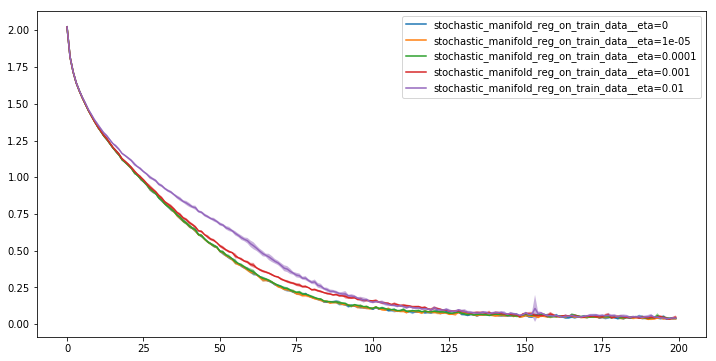

In [28]:
plt.figure(figsize=(12, 6))

for mode in modes:
    plt.plot(train_losses[mode].mean(axis=0))
    plt.fill_between(
        range(num_epochs),
        train_losses[mode].mean(axis=0) - train_losses[mode].std(axis=0),
        train_losses[mode].mean(axis=0) + train_losses[mode].std(axis=0),
        alpha=0.5
    )
plt.legend(modes)

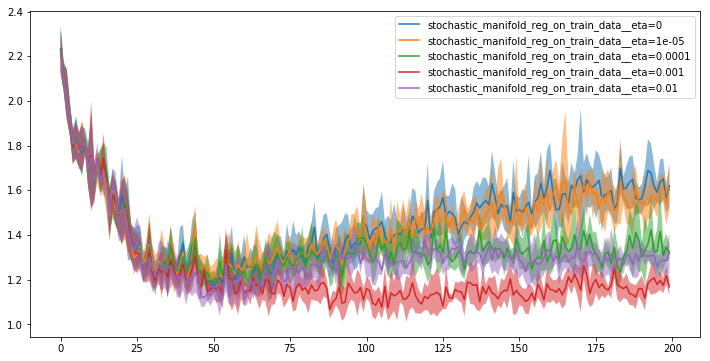

In [29]:
plt.figure(figsize=(12, 6))

for mode in modes:
    plt.plot(test_losses[mode].mean(axis=0))
    plt.fill_between(
        range(num_epochs),
        test_losses[mode].mean(axis=0) - test_losses[mode].std(axis=0),
        test_losses[mode].mean(axis=0) + test_losses[mode].std(axis=0),
        alpha=0.5
    )
plt.legend(modes)

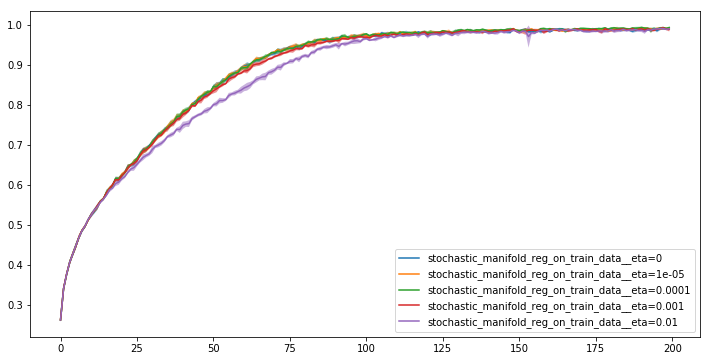

In [30]:
plt.figure(figsize=(12, 6))

for mode in modes:
    plt.plot(train_accs[mode].mean(axis=0))
    plt.fill_between(
        range(num_epochs),
        train_accs[mode].mean(axis=0) - train_accs[mode].std(axis=0),
        train_accs[mode].mean(axis=0) + train_accs[mode].std(axis=0),
        alpha=0.5
    )
plt.legend(modes)

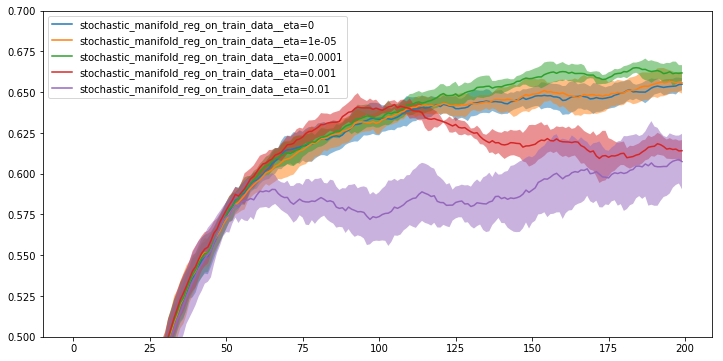

In [33]:
plt.figure(figsize=(12, 6))

alpha = 0.1
for mode in modes:
    curve = DataFrame(test_accs[mode]).ewm(alpha=alpha, axis=1).mean()
    plt.plot(curve.mean(axis=0))
    plt.fill_between(
        range(num_epochs),
        curve.mean(axis=0) - curve.std(axis=0),
        curve.mean(axis=0) + curve.std(axis=0),
        alpha=0.5
    )
plt.ylim(0.5, 0.7)
plt.legend(modes)

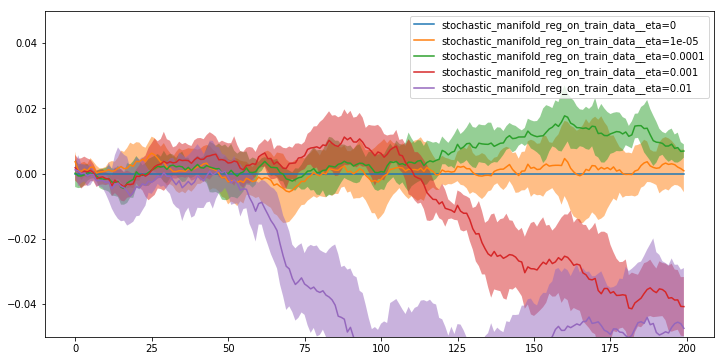

In [34]:
plt.figure(figsize=(12, 6))

for mode in modes:
    curve = DataFrame(test_accs[mode] - test_accs[modes[0]]).ewm(alpha=alpha, axis=1).mean()
    plt.plot(curve.mean(axis=0))
    plt.fill_between(
        range(num_epochs),
        curve.mean(axis=0) - curve.std(axis=0),
        curve.mean(axis=0) + curve.std(axis=0),
        alpha=0.5
    )
plt.ylim(-0.05, 0.05)
plt.legend(modes)

In [36]:
for mode in modes:
    print('{}: {:.2f} +- {:.2f}'.format(
        mode, 
        DataFrame(test_accs[mode]).ewm(alpha=alpha, axis=1).mean().mean(axis=0).max() * 100, 
        DataFrame(test_accs[mode]).ewm(alpha=alpha, axis=1).mean().std(axis=0)[
            np.argmax(DataFrame(test_accs[mode]).ewm(alpha=alpha, axis=1).mean().mean(axis=0))
        ] * 100, 
    ))

stochastic_manifold_reg_on_train_data__eta=0: 65.49 +- 0.37
stochastic_manifold_reg_on_train_data__eta=1e-05: 65.65 +- 0.70
stochastic_manifold_reg_on_train_data__eta=0.0001: 66.50 +- 0.31
stochastic_manifold_reg_on_train_data__eta=0.001: 64.24 +- 0.27
stochastic_manifold_reg_on_train_data__eta=0.01: 60.87 +- 1.47
